In [1]:
import pickle
from urllib.request import urlopen
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(42)
np.random.RandomState(42)
import warnings
import sklearn.exceptions
warnings.filterwarnings("ignore", category=sklearn.exceptions.ConvergenceWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
import seaborn as sns
import time
import statsmodels.api as sm
from scipy import stats
from scipy.stats import norm, skew, kurtosis
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV,cross_val_score 
from sklearn import preprocessing
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor, AdaBoostRegressor
from xgboost.sklearn import XGBRegressor
from sklearn.metrics import mean_absolute_error,r2_score, mean_squared_log_error,mean_squared_error, make_scorer

In [2]:
london = pd.read_csv("finaldf_with_weather.csv")
london.head()

,StartStation Id,trips,StartDate,real_temp,humidity,feel_temp,precipitation,rain,snowfall,weather_code,cloud_cover,wind_speed
0,108,7,2017-01-01 00:00:00,5.5,96,2.3,0.0,0.0,0.0,2,68,25.8
1,151,1,2017-01-01 00:00:00,5.5,96,2.3,0.0,0.0,0.0,2,68,25.8
2,594,2,2017-01-01 00:00:00,5.5,96,2.3,0.0,0.0,0.0,2,68,25.8
3,37,1,2017-01-01 00:00:00,5.5,96,2.3,0.0,0.0,0.0,2,68,25.8
4,206,1,2017-01-01 00:00:00,5.5,96,2.3,0.0,0.0,0.0,2,68,25.8


In [5]:
london.describe()

,StartStation Id,trips,StartDate,real_temp,humidity,feel_temp,precipitation,rain,snowfall,weather_code,cloud_cover,wind_speed
count,3.256360e+06,3.256360e+06,3256360,3.256360e+06,3.256360e+06,3.256360e+06,3.256360e+06,3.256360e+06,3.256360e+06,3.256360e+06,3.256360e+06,3.256360e+06
mean,3.921295e+02,3.187400e+00,2017-07-03 00:44:05.986070272,1.257818e+01,7.525205e+01,1.005210e+01,6.047105e-02,5.909319e-02,9.645002e-04,9.338591e+00,6.091177e+01,2.404996e+01
min,1.000000e+00,1.000000e+00,2017-01-01 00:00:00,-4.800000e+00,3.600000e+01,-9.100000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,5.000000e-01
25%,1.830000e+02,1.000000e+00,2017-04-09 20:00:00,8.400000e+00,6.500000e+01,4.900000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,2.800000e+01,1.650000e+01
50%,3.770000e+02,2.000000e+00,2017-07-03 09:00:00,1.310000e+01,7.700000e+01,1.030000e+01,0.000000e+00,0.000000e+00,0.000000e+00,2.000000e+00,6.800000e+01,2.350000e+01
75%,6.020000e+02,4.000000e+00,2017-09-26 10:00:00,1.700000e+01,8.700000e+01,1.530000e+01,0.000000e+00,0.000000e+00,0.000000e+00,3.000000e+00,1.000000e+02,3.100000e+01
max,8.260000e+02,2.390000e+02,2018-01-01 00:00:00,3.160000e+01,1.000000e+02,3.350000e+01,4.700000e+00,4.700000e+00,2.380000e+00,7.500000e+01,1.000000e+02,7.750000e+01
std,2.396232e+02,4.225593e+00,NaN,6.103265e+00,1.403209e+01,7.231230e+00,2.527198e-01,2.428029e-01,3.446818e-02,1.820004e+01,3.631552e+01,1.091379e+01


In [6]:
london.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3256360 entries, 0 to 3256359
Data columns (total 12 columns):
 #   Column           Dtype         
---  ------           -----         
 0   StartStation Id  int64         
 1   trips            int64         
 2   StartDate        datetime64[ns]
 3   real_temp        float64       
 4   humidity         int64         
 5   feel_temp        float64       
 6   precipitation    float64       
 7   rain             float64       
 8   snowfall         float64       
 9   weather_code     int64         
 10  cloud_cover      int64         
 11  wind_speed       float64       
dtypes: datetime64[ns](1), float64(6), int64(5)
memory usage: 298.1 MB


In [4]:
london.rename(columns={"StartDate":"timestamp", "trips":"cnt"}, inplace=True)

In [5]:
london['weather_code'].unique()
#1 = Clear ; mostly clear but have some values with haze/fog/patches of fog/ fog in vicinity
#2 = scattered clouds / few clouds
#3 = Broken clouds
#4 = Cloudly
#7 = Rain/ light Rain shower/ Light rain
#10 = rain with thunderstorm
#26 = snowfall
#94 = Freezing Fog


array([ 2,  3, 51, 61, 53,  1,  0, 63, 55, 75, 73, 71], dtype=int64)

In [6]:
weather_dict = {1 : 100,  2 : 100,  3 : 100,  4 : 100, 
                7 : 200, 10 : 200, 26 : 200, 94 : 200}
london['weather_code']=london['weather_code'].replace(weather_dict)

In [7]:
london['count_log'] = np.log1p(london['cnt'])

C:\Users\jkaed\AppData\Local\Temp\ipykernel_21128\4024311444.py:13: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(london[col], ax=axs,**kwargs)


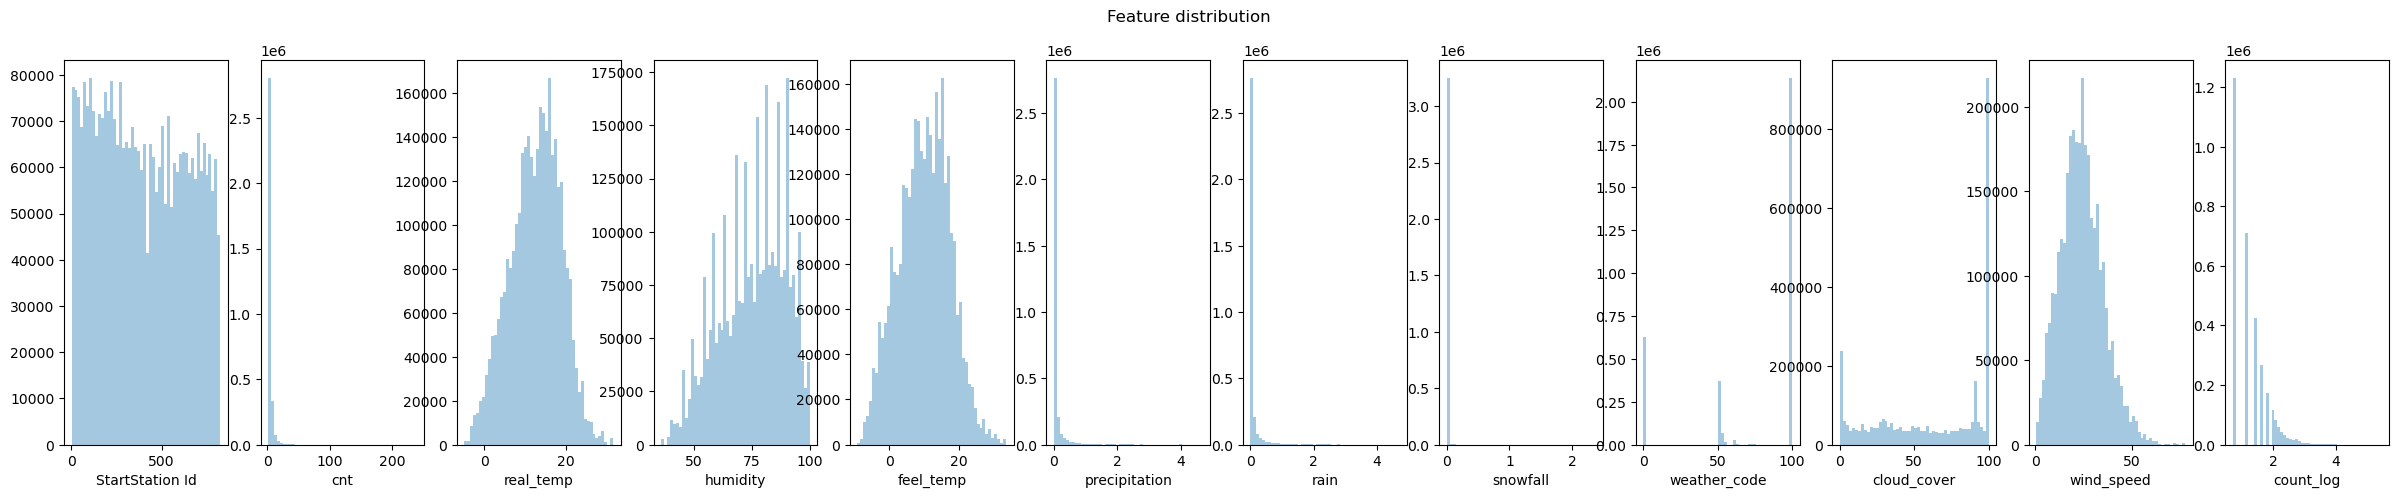

In [8]:
def plot_distribution(london,columns,**kwargs ):
    """
    Function to plot a dataframe feature distribution.
    Input: 
    df - pandas DataFrame.
    columns - list of the df columns that should be plotted
    Output: multiple feature histograms
    
    Note: String columns should be dropped before passing to the function.
    """
    fig, axes = plt.subplots(ncols=len(columns),figsize=(30,5))
    for axs, col in zip(axes, columns):
        sns.distplot(london[col], ax=axs,**kwargs)
    fig.suptitle('Feature distribution')
    
plot_distribution(london,london.drop(['timestamp'],axis=1).columns, kde=False)

In [9]:
london.head()

,StartStation Id,cnt,timestamp,real_temp,humidity,feel_temp,precipitation,rain,snowfall,weather_code,cloud_cover,wind_speed,count_log
0,108,7,2017-01-01,5.5,96,2.3,0.0,0.0,0.0,100,68,25.8,2.079442
1,151,1,2017-01-01,5.5,96,2.3,0.0,0.0,0.0,100,68,25.8,0.693147
2,594,2,2017-01-01,5.5,96,2.3,0.0,0.0,0.0,100,68,25.8,1.098612
3,37,1,2017-01-01,5.5,96,2.3,0.0,0.0,0.0,100,68,25.8,0.693147
4,206,1,2017-01-01,5.5,96,2.3,0.0,0.0,0.0,100,68,25.8,0.693147


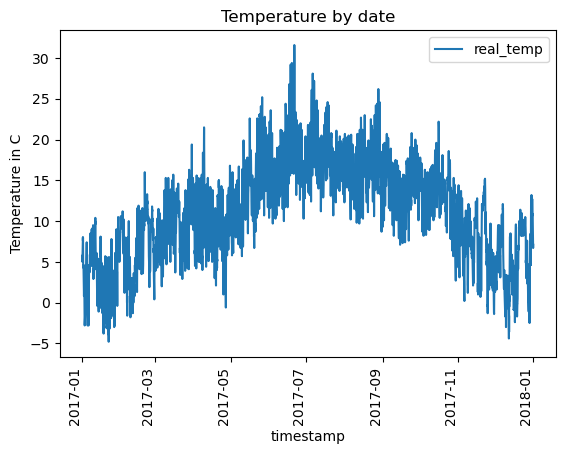

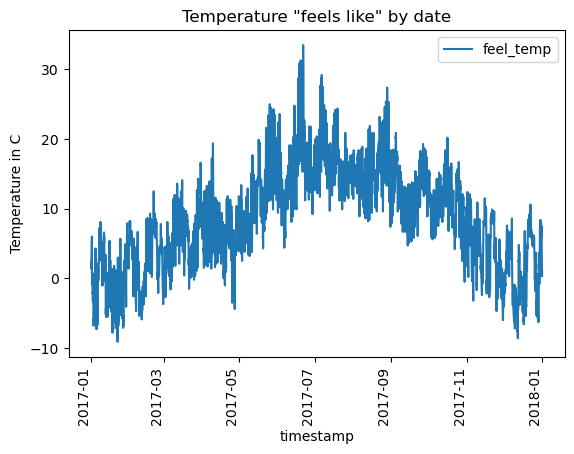

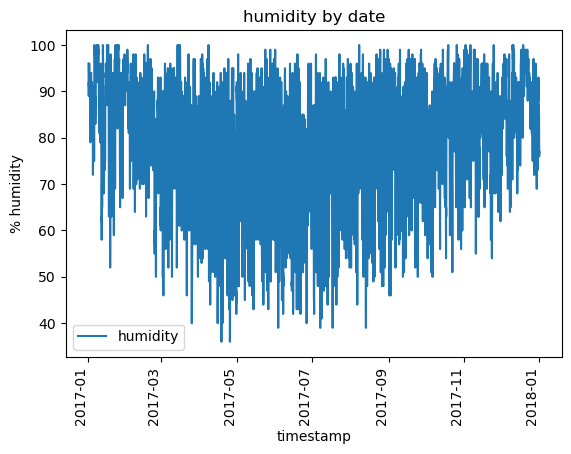

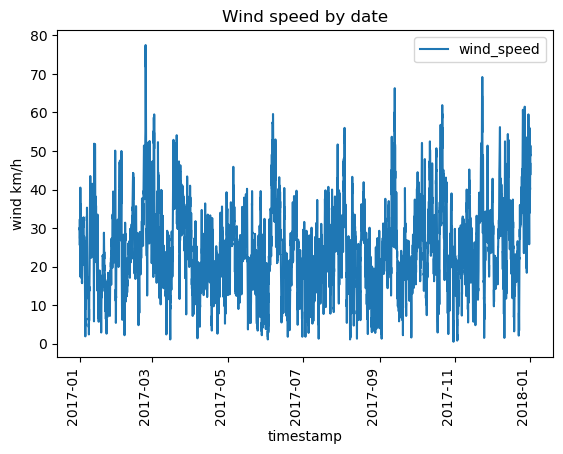

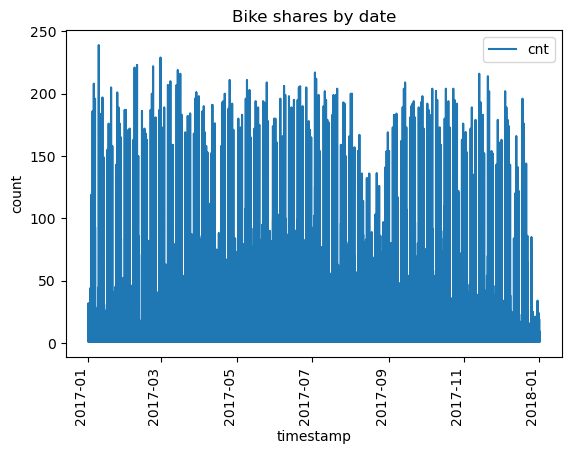

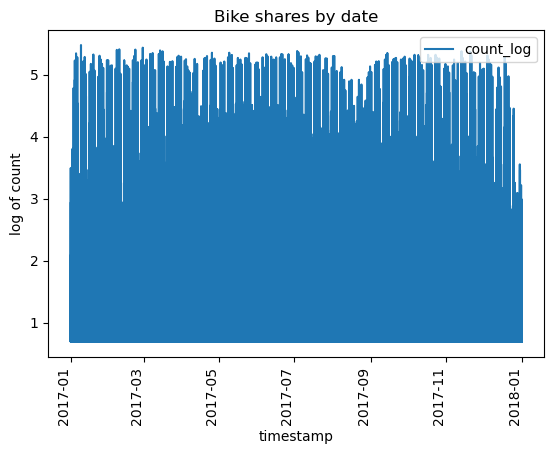

In [10]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_by_time(df, column, main_title, yaxis, months=None):
    """
    Plot values by timestamp for specified months.
    
    Inputs:
    df - pandas DataFrame
    column - name of the column to plot
    main_title - string for title of the plot
    yaxis - string for y axis label
    months - list of integers representing the months to include in the plot (1-12). If None, all months are included.
    """
    # Filter DataFrame by months if specified
    if months is not None:
        df = df[df['timestamp'].dt.month.isin(months)]
    
    ax = df.plot(x='timestamp', y=column, rot=90)
    plt.title(main_title)
    plt.ylabel(yaxis)
    plt.show()

# Example usage:
# plot_by_time(london, 'real_temp', 'Temperature by date', 'Temperature in C', months=[1, 2, 3, 4, 5, 6])


#ax.set_xticklabels(pd.to_datetime(london.timestamp), rotation=90)
plot_by_time(london,'real_temp','Temperature by date','Temperature in C')
plot_by_time(london,'feel_temp','Temperature "feels like" by date','Temperature in C')
plot_by_time(london,'humidity','humidity by date','% humidity')
plot_by_time(london,'wind_speed','Wind speed by date','wind km/h')
plot_by_time(london, 'cnt','Bike shares by date','count')
plot_by_time(london,'count_log','Bike shares by date','log of count')

In [8]:
# Create a DataFrame with the holiday data
holiday_data = [
    {'Date': '02-01-2017', 'Holiday': "New Year's Day"},
    #{'Date': '02-01-2017', 'Holiday': '2nd January', 'Region': 'Scotland'},
    {'Date': '17-03-2017', 'Holiday': "St Patrick's Day", 'Region': 'Northern Ireland'},
    {'Date': '14-04-2017', 'Holiday': 'Good Friday'},
    {'Date': '17-04-2017', 'Holiday': 'Easter Monday', 'Region': 'England and Wales, Northern Ireland'},
    {'Date': '01-05-2017', 'Holiday': 'Early May Bank Holiday (May Day)'},
    {'Date': '29-05-2017', 'Holiday': 'Late May Bank Holiday'},
    {'Date': '12-07-2017', 'Holiday': 'Battle of the Boyne', 'Region': 'Northern Ireland'},
    {'Date': '07-08-2017', 'Holiday': 'August Bank Holiday (Scotland)', 'Region': 'Scotland'},
    {'Date': '28-08-2017', 'Holiday': 'August Bank Holiday', 'Region': 'England and Wales, Northern Ireland'},
    {'Date': '30-11-2017', 'Holiday': "St Andrew's Day", 'Region': 'Scotland'},
    {'Date': '25-12-2017', 'Holiday': 'Christmas Day'},
    {'Date': '26-12-2017', 'Holiday': 'Boxing Day'}
]

holiday_df = pd.DataFrame(holiday_data)

holiday_df.drop(['Holiday', 'Region'], axis=1, inplace=True)

# Convert the 'Date' column in the holiday dates table to datetime format
holiday_df['Date'] = pd.to_datetime(holiday_df['Date'], format='%d-%m-%Y')
london['timestamp'] = pd.to_datetime(london['timestamp'])  # Ensure 'StartDate' column is in datetime format
merged_df = pd.merge(london, holiday_df, left_on=london['timestamp'].dt.strftime('%Y-%m-%d'), right_on=holiday_df['Date'].dt.strftime('%Y-%m-%d'), how='left')
#merged_df = pd.merge(london, holiday_df, left_on='timestamp', right_on='Date', how='left')

# Set the 'is_holiday' column to 1 for rows where there is a match between the 'StartDate' and a holiday date, and 0 otherwise
merged_df['is_holiday'] = merged_df['Date'].notnull().astype(int)
merged_df["is_holiday"].describe()

merged_df.drop(columns=["key_0", "Date"], inplace=True)

london = merged_df.copy()
london.shape

(3256360, 14)

In [9]:
dates = london["timestamp"]
london["is_weekend"] = dates.dt.day_name().isin(['Saturday', 'Sunday'])

In [10]:
london_non_weekend = london[london['is_weekend'] == 0]
london_non_weekend = london_non_weekend.drop(['is_holiday','is_weekend'],axis=1)
london_is_weekend = london[london['is_weekend'] == 1]
london_is_weekend = london_is_weekend.drop(['is_holiday','is_weekend'],axis=1)
london_is_holiday = london[london['is_holiday'] == 1]
london_is_holiday = london_is_holiday.drop(['is_holiday','is_weekend'],axis=1)
london_non_holiday = london[london['is_holiday'] == 0]
london_non_holiday = london_non_holiday.drop(['is_holiday','is_weekend'],axis=1)

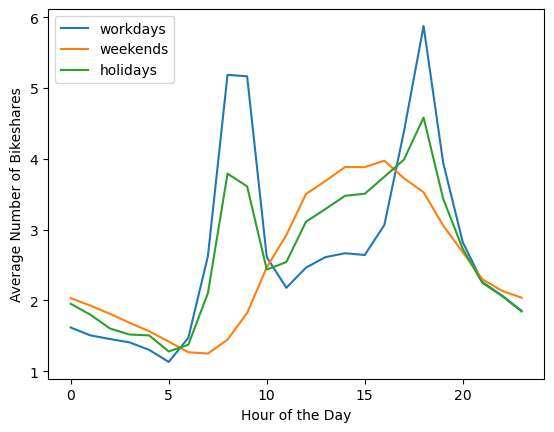

In [78]:
def hourly_plot(df,title):
    """
    Function for plotting bike shares by hour.
    input: 
    df - pandas dataframe 
    title - main title of the plot
    
    """
    #assert_true('timestamp' in set(df.columns))
    #assert_true('cnt' in set(df.columns))
    
    df.groupby(by=df.timestamp.dt.hour)['cnt'].mean().plot()
    plt.title(title)
    plt.ylabel('Average Number of Bikeshares')
    plt.xlabel('Hour of the Day')
    plt.legend(['workdays','weekends','holidays'],loc=2, fontsize = 'medium')
    
hourly_plot(london_non_weekend, '')
hourly_plot(london_is_weekend, '')
hourly_plot(london_is_holiday, '')

plt.savefig("workdays_weekends_holidays_comparison-png")

In [15]:
london.corr()

,StartStation Id,cnt,timestamp,real_temp,humidity,feel_temp,precipitation,rain,snowfall,weather_code,cloud_cover,wind_speed,count_log,is_holiday,is_weekend
StartStation Id,1.000000,-0.097260,0.006943,0.014148,-0.005478,0.015067,-0.005525,-0.005429,-0.001587,-0.001017,-0.006456,-0.007798,-0.113777,0.001224,0.019385
cnt,-0.097260,1.000000,0.001700,0.102301,-0.102808,0.097091,-0.030293,-0.029726,-0.008896,0.018694,-0.012635,-0.025565,0.803252,-0.003406,-0.032720
timestamp,0.006943,0.001700,1.000000,0.168864,0.071285,0.178366,0.003689,0.004322,-0.002377,0.038004,0.010214,0.052367,0.006095,0.002871,0.006922
real_temp,0.014148,0.102301,0.168864,1.000000,-0.557583,0.981930,0.005912,0.016293,-0.049998,0.131600,0.077787,-0.054054,0.150531,-0.010876,0.046236
humidity,-0.005478,-0.102808,0.071285,-0.557583,1.000000,-0.457273,0.127486,0.123573,0.044971,-0.047009,0.108786,-0.023635,-0.156061,-0.023373,-0.070073
feel_temp,0.015067,0.097091,0.178366,0.981930,-0.457273,1.000000,0.006541,0.017353,-0.051996,0.112879,0.057187,-0.202978,0.142119,-0.012744,0.040187
precipitation,-0.005525,-0.030293,0.003689,0.005912,0.127486,0.006541,1.000000,0.981045,0.294867,-0.105362,0.190005,0.080706,-0.044021,0.005654,-0.010646
rain,-0.005429,-0.029726,0.004322,0.016293,0.123573,0.017353,0.981045,1.000000,0.104111,-0.109746,0.191939,0.079462,-0.042998,0.006861,-0.012636
snowfall,-0.001587,-0.008896,-0.002377,-0.049998,0.044971,-0.051996,0.294867,0.104111,1.000000,0.000402,0.028728,0.022386,-0.013908,-0.004814,0.007670
weather_code,-0.001017,0.018694,0.038004,0.131600,-0.047009,0.112879,-0.105362,-0.109746,0.000402,1.000000,0.605505,0.039085,0.028627,-0.006699,-0.006879


In [19]:
london_is_weekend.corr()

,StartStation Id,cnt,timestamp,real_temp,humidity,feel_temp,precipitation,rain,snowfall,weather_code,cloud_cover,wind_speed,count_log
StartStation Id,1.000000,-0.035408,0.004795,0.023321,-0.025183,0.021534,-0.000918,-0.001449,0.001875,0.001389,-0.000195,-0.006559,-0.037108
cnt,-0.035408,1.000000,-0.010790,0.207554,-0.241707,0.190451,-0.041282,-0.039126,-0.016501,0.024200,-0.012641,-0.034268,0.854193
timestamp,0.004795,-0.010790,1.000000,0.104095,0.082879,0.115811,0.010382,-0.002571,0.052163,0.016622,-0.039198,0.054553,-0.007726
real_temp,0.023321,0.207554,0.104095,1.000000,-0.625959,0.980542,-0.055287,-0.039673,-0.071329,0.129710,0.022551,-0.070905,0.264089
humidity,-0.025183,-0.241707,0.082879,-0.625959,1.000000,-0.522903,0.167200,0.160107,0.060488,-0.094432,0.089999,0.004623,-0.307401
feel_temp,0.021534,0.190451,0.115811,0.980542,-0.522903,1.000000,-0.045489,-0.030334,-0.067616,0.096511,-0.005662,-0.220835,0.241963
precipitation,-0.000918,-0.041282,0.010382,-0.055287,0.167200,-0.045489,1.000000,0.969455,0.315816,-0.107565,0.211359,0.034588,-0.055199
rain,-0.001449,-0.039126,-0.002571,-0.039673,0.160107,-0.030334,0.969455,1.000000,0.073451,-0.113254,0.212848,0.037480,-0.051477
snowfall,0.001875,-0.016501,0.052163,-0.071329,0.060488,-0.067616,0.315816,0.073451,1.000000,0.000748,0.036018,-0.004350,-0.025307
weather_code,0.001389,0.024200,0.016622,0.129710,-0.094432,0.096511,-0.107565,-0.113254,0.000748,1.000000,0.580931,0.075207,0.034964


In [20]:
london_non_weekend.corr()

,StartStation Id,cnt,timestamp,real_temp,humidity,feel_temp,precipitation,rain,snowfall,weather_code,cloud_cover,wind_speed,count_log
StartStation Id,1.000000,-0.114600,0.007493,0.009850,0.003852,0.011873,-0.006689,-0.006337,-0.003282,-0.001680,-0.008284,-0.008002,-0.138246
cnt,-0.114600,1.000000,0.005435,0.075649,-0.064347,0.073660,-0.028009,-0.027946,-0.006110,0.016936,-0.013251,-0.023636,0.791145
timestamp,0.007493,0.005435,1.000000,0.189993,0.068066,0.198542,0.001790,0.006474,-0.024919,0.045318,0.026893,0.051744,0.010909
real_temp,0.009850,0.075649,0.189993,1.000000,-0.531487,0.982379,0.024951,0.033703,-0.042116,0.132878,0.097343,-0.048174,0.116998
humidity,0.003852,-0.064347,0.068066,-0.531487,1.000000,-0.432393,0.114292,0.111455,0.038853,-0.029862,0.115079,-0.034763,-0.106927
feel_temp,0.011873,0.073660,0.198542,0.982379,-0.432393,1.000000,0.022562,0.032038,-0.046518,0.118912,0.078914,-0.197050,0.112932
precipitation,-0.006689,-0.028009,0.001790,0.024951,0.114292,0.022562,1.000000,0.984180,0.291308,-0.104985,0.183620,0.094207,-0.041418
rain,-0.006337,-0.027946,0.006474,0.033703,0.111455,0.032038,0.984180,1.000000,0.117214,-0.109050,0.185810,0.091594,-0.041329
snowfall,-0.003282,-0.006110,-0.024919,-0.042116,0.038853,-0.046518,0.291308,0.117214,1.000000,0.000333,0.025983,0.033506,-0.009008
weather_code,-0.001680,0.016936,0.045318,0.132878,-0.029862,0.118912,-0.104985,-0.109050,0.000333,1.000000,0.614009,0.026983,0.026188


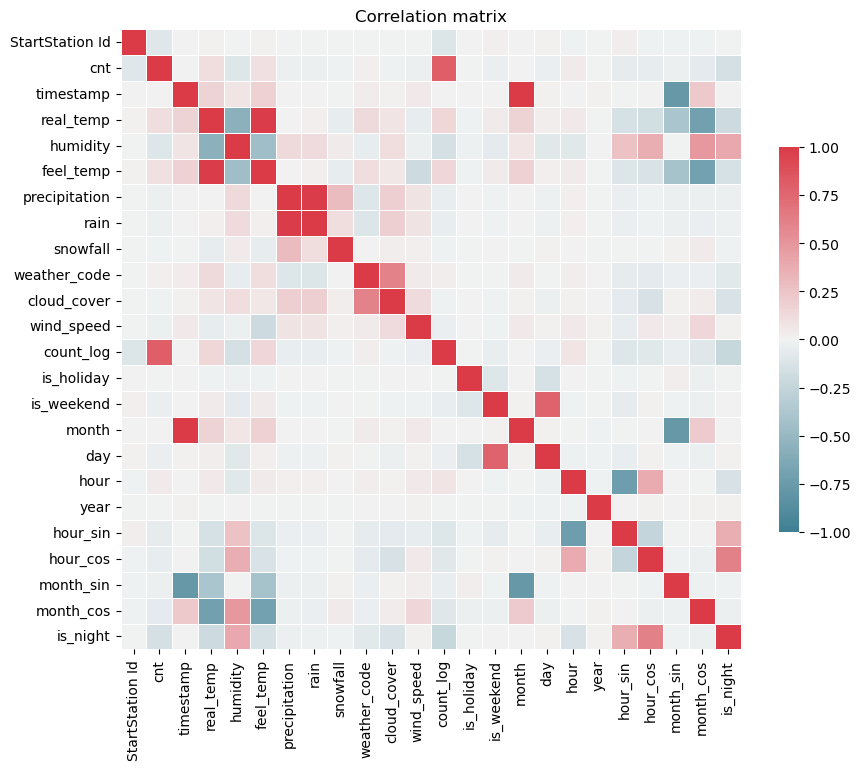

In [80]:
def plot_heatmap_corr(df):
    """
    Plot correlation heatmap from pandas dataframe.
    Input:pandas dataframe
    
    Output: Correlation heatmap
    
    """
    #assert_is_not_none(df)
    #assert_is_instance(df, pd.DataFrame)
    
    f, ax = plt.subplots(figsize=(10, 10))
    cmap = sns.diverging_palette(220, 10, as_cmap=True)
    sns.heatmap(df.corr(), cmap=cmap, vmax=1.0, vmin=-1.0, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5})
    plt.title('Correlation matrix')
    plt.savefig("correlation_matrix.png")
plot_heatmap_corr(london)

## 2.Feature engineering

In [11]:
def add_non_workday(df):
    """
    The function is grouping "is_holiday" and "is_weekend" columns into a new one "is_non_workday"
    Input: pandas DataFrame that contains columns 'is_holiday','is_weekend'
    """
    
    df['is_non_workday'] = df['is_holiday'] + df['is_weekend']
    df = df.drop(['is_holiday','is_weekend'],axis=1)
        
    return df

In [12]:
def add_month(df):
    """
    The function is extracting the month of a timestamp into a new column.
    Input: pandas DataFrame that contains 'timestamp' column
    """    
    df['month'] = df['timestamp'].dt.month
    
    return df

In [13]:
def add_year(df):
    """
    The function is extracting the year of a timestamp into a new column.
    Input: pandas DataFrame that contains 'timestamp' column
    """    
    df['year'] = df['timestamp'].dt.year
    
    return df

In [14]:
def add_day_of_week(df):
    """
    The function is extracting the day of the week of a timestamp into a new column.
    Input: pandas DataFrame that contains 'timestamp' column
    """
    
    df['day']=df['timestamp'].dt.dayofweek
    
    return df


In [15]:
def add_hour(df):
    """
    The function is extracting the hour of a timestamp into a new column.
    Input: pandas DataFrame that contains 'timestamp' column
    """    
    df['hour'] = df['timestamp'].dt.hour
    
    return df

In [16]:
def add_encode(df, column, max_value):
    """
    The function is encoding time series cyclical features with sin and cos.
    Input: 
    ---------
    df - pandas DataFrame
    column - column name
    max_value - column max value
    Output: 
    -----------
    -same dataframe with _sin and _cos columns added
    """
    
    df[column + '_sin'] = np.sin(2 * np.pi * df[column] / max_value)
    df[column + '_cos'] = np.cos(2 * np.pi * df[column] / max_value)
    
    return df

In [17]:
#london=add_non_workday(london)
add_month(london)
add_day_of_week(london)
add_hour(london)
add_year(london)
add_encode(london,'hour',23)
add_encode(london,'month',12)

,StartStation Id,cnt,timestamp,real_temp,humidity,feel_temp,precipitation,rain,snowfall,weather_code,...,is_holiday,is_weekend,month,day,hour,year,hour_sin,hour_cos,month_sin,month_cos
0,108,7,2017-01-01,5.5,96,2.3,0.0,0.0,0.0,100,...,0,True,1,6,0,2017,0.0,1.0,0.5,0.866025
1,151,1,2017-01-01,5.5,96,2.3,0.0,0.0,0.0,100,...,0,True,1,6,0,2017,0.0,1.0,0.5,0.866025
2,594,2,2017-01-01,5.5,96,2.3,0.0,0.0,0.0,100,...,0,True,1,6,0,2017,0.0,1.0,0.5,0.866025
3,37,1,2017-01-01,5.5,96,2.3,0.0,0.0,0.0,100,...,0,True,1,6,0,2017,0.0,1.0,0.5,0.866025
4,206,1,2017-01-01,5.5,96,2.3,0.0,0.0,0.0,100,...,0,True,1,6,0,2017,0.0,1.0,0.5,0.866025
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3256355,81,1,2018-01-01,7.1,77,1.0,0.0,0.0,0.0,100,...,0,False,1,0,0,2018,0.0,1.0,0.5,0.866025
3256356,230,3,2018-01-01,7.1,77,1.0,0.0,0.0,0.0,100,...,0,False,1,0,0,2018,0.0,1.0,0.5,0.866025
3256357,540,1,2018-01-01,7.1,77,1.0,0.0,0.0,0.0,100,...,0,False,1,0,0,2018,0.0,1.0,0.5,0.866025
3256358,759,3,2018-01-01,7.1,77,1.0,0.0,0.0,0.0,100,...,0,False,1,0,0,2018,0.0,1.0,0.5,0.866025


In [18]:
london[london['count_log']<6].groupby(by='day').count()

,StartStation Id,cnt,timestamp,real_temp,humidity,feel_temp,precipitation,rain,snowfall,weather_code,...,count_log,is_holiday,is_weekend,month,hour,year,hour_sin,hour_cos,month_sin,month_cos
day,,,,,,,,,,,,,,,,,,,,,
0,464498,464498,464498,464498,464498,464498,464498,464498,464498,464498,...,464498,464498,464498,464498,464498,464498,464498,464498,464498,464498
1,482997,482997,482997,482997,482997,482997,482997,482997,482997,482997,...,482997,482997,482997,482997,482997,482997,482997,482997,482997,482997
2,478263,478263,478263,478263,478263,478263,478263,478263,478263,478263,...,478263,478263,478263,478263,478263,478263,478263,478263,478263,478263
3,493399,493399,493399,493399,493399,493399,493399,493399,493399,493399,...,493399,493399,493399,493399,493399,493399,493399,493399,493399,493399
4,491060,491060,491060,491060,491060,491060,491060,491060,491060,491060,...,491060,491060,491060,491060,491060,491060,491060,491060,491060,491060
5,433851,433851,433851,433851,433851,433851,433851,433851,433851,433851,...,433851,433851,433851,433851,433851,433851,433851,433851,433851,433851
6,412292,412292,412292,412292,412292,412292,412292,412292,412292,412292,...,412292,412292,412292,412292,412292,412292,412292,412292,412292,412292


In [19]:
london[london['count_log']<6].groupby(by='month').count()

,StartStation Id,cnt,timestamp,real_temp,humidity,feel_temp,precipitation,rain,snowfall,weather_code,...,count_log,is_holiday,is_weekend,day,hour,year,hour_sin,hour_cos,month_sin,month_cos
month,,,,,,,,,,,,,,,,,,,,,
1,233930,233930,233930,233930,233930,233930,233930,233930,233930,233930,...,233930,233930,233930,233930,233930,233930,233930,233930,233930,233930
2,223715,223715,223715,223715,223715,223715,223715,223715,223715,223715,...,223715,223715,223715,223715,223715,223715,223715,223715,223715,223715
3,271068,271068,271068,271068,271068,271068,271068,271068,271068,271068,...,271068,271068,271068,271068,271068,271068,271068,271068,271068,271068
4,276417,276417,276417,276417,276417,276417,276417,276417,276417,276417,...,276417,276417,276417,276417,276417,276417,276417,276417,276417,276417
5,294988,294988,294988,294988,294988,294988,294988,294988,294988,294988,...,294988,294988,294988,294988,294988,294988,294988,294988,294988,294988
6,305546,305546,305546,305546,305546,305546,305546,305546,305546,305546,...,305546,305546,305546,305546,305546,305546,305546,305546,305546,305546
7,312213,312213,312213,312213,312213,312213,312213,312213,312213,312213,...,312213,312213,312213,312213,312213,312213,312213,312213,312213,312213
8,289801,289801,289801,289801,289801,289801,289801,289801,289801,289801,...,289801,289801,289801,289801,289801,289801,289801,289801,289801,289801
9,279875,279875,279875,279875,279875,279875,279875,279875,279875,279875,...,279875,279875,279875,279875,279875,279875,279875,279875,279875,279875


In [20]:
london[london['count_log']<6].groupby(by='hour').count()

,StartStation Id,cnt,timestamp,real_temp,humidity,feel_temp,precipitation,rain,snowfall,weather_code,...,count_log,is_holiday,is_weekend,month,day,year,hour_sin,hour_cos,month_sin,month_cos
hour,,,,,,,,,,,,,,,,,,,,,
0,70163,70163,70163,70163,70163,70163,70163,70163,70163,70163,...,70163,70163,70163,70163,70163,70163,70163,70163,70163,70163
1,46636,46636,46636,46636,46636,46636,46636,46636,46636,46636,...,46636,46636,46636,46636,46636,46636,46636,46636,46636,46636
2,32514,32514,32514,32514,32514,32514,32514,32514,32514,32514,...,32514,32514,32514,32514,32514,32514,32514,32514,32514,32514
3,21992,21992,21992,21992,21992,21992,21992,21992,21992,21992,...,21992,21992,21992,21992,21992,21992,21992,21992,21992,21992
4,17435,17435,17435,17435,17435,17435,17435,17435,17435,17435,...,17435,17435,17435,17435,17435,17435,17435,17435,17435,17435
5,21063,21063,21063,21063,21063,21063,21063,21063,21063,21063,...,21063,21063,21063,21063,21063,21063,21063,21063,21063,21063
6,64590,64590,64590,64590,64590,64590,64590,64590,64590,64590,...,64590,64590,64590,64590,64590,64590,64590,64590,64590,64590
7,135924,135924,135924,135924,135924,135924,135924,135924,135924,135924,...,135924,135924,135924,135924,135924,135924,135924,135924,135924,135924
8,190820,190820,190820,190820,190820,190820,190820,190820,190820,190820,...,190820,190820,190820,190820,190820,190820,190820,190820,190820,190820


In [21]:
def add_night_hours(df):
    """
    The function is creating a new column "is_night". It requires a column with hours.
    If the hour is from 8:00 to 20:00 the data is classified as 0, if not in this interval it's 1.
    The purpose is try to to catch the sunlight status, but it's not taking in acount the time of the year and summertime.
    
    Input:
    df- pandas DataFrame, containing 'hour' column
    Output :
    Pandas DataFrame with added "is_night column"
    """    
    df['is_night'] = 0
    df.loc[(df['hour'] < 8) | (df['hour'] > 20), 'is_night'] = 1
    
    return df

In [22]:
add_night_hours(london)

,StartStation Id,cnt,timestamp,real_temp,humidity,feel_temp,precipitation,rain,snowfall,weather_code,...,is_weekend,month,day,hour,year,hour_sin,hour_cos,month_sin,month_cos,is_night
0,108,7,2017-01-01,5.5,96,2.3,0.0,0.0,0.0,100,...,True,1,6,0,2017,0.0,1.0,0.5,0.866025,1
1,151,1,2017-01-01,5.5,96,2.3,0.0,0.0,0.0,100,...,True,1,6,0,2017,0.0,1.0,0.5,0.866025,1
2,594,2,2017-01-01,5.5,96,2.3,0.0,0.0,0.0,100,...,True,1,6,0,2017,0.0,1.0,0.5,0.866025,1
3,37,1,2017-01-01,5.5,96,2.3,0.0,0.0,0.0,100,...,True,1,6,0,2017,0.0,1.0,0.5,0.866025,1
4,206,1,2017-01-01,5.5,96,2.3,0.0,0.0,0.0,100,...,True,1,6,0,2017,0.0,1.0,0.5,0.866025,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3256355,81,1,2018-01-01,7.1,77,1.0,0.0,0.0,0.0,100,...,False,1,0,0,2018,0.0,1.0,0.5,0.866025,1
3256356,230,3,2018-01-01,7.1,77,1.0,0.0,0.0,0.0,100,...,False,1,0,0,2018,0.0,1.0,0.5,0.866025,1
3256357,540,1,2018-01-01,7.1,77,1.0,0.0,0.0,0.0,100,...,False,1,0,0,2018,0.0,1.0,0.5,0.866025,1
3256358,759,3,2018-01-01,7.1,77,1.0,0.0,0.0,0.0,100,...,False,1,0,0,2018,0.0,1.0,0.5,0.866025,1


In [23]:
def sns_hist(data,title):
    """"
    Function to plot seaborn histogram.
    """    
    sns.distplot(data, fit=norm)
    plt.title(title)
    plt.ylabel('Density')

C:\Users\jkaed\AppData\Local\Temp\ipykernel_24144\3045206472.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data, fit=norm)


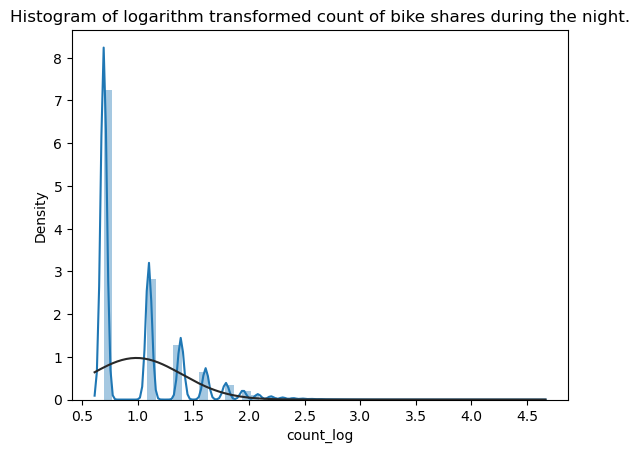

In [24]:
sns_hist(london[london['is_night']==1]['count_log'],"Histogram of logarithm transformed count of bike shares during the night.")

C:\Users\jkaed\AppData\Local\Temp\ipykernel_24144\3045206472.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data, fit=norm)


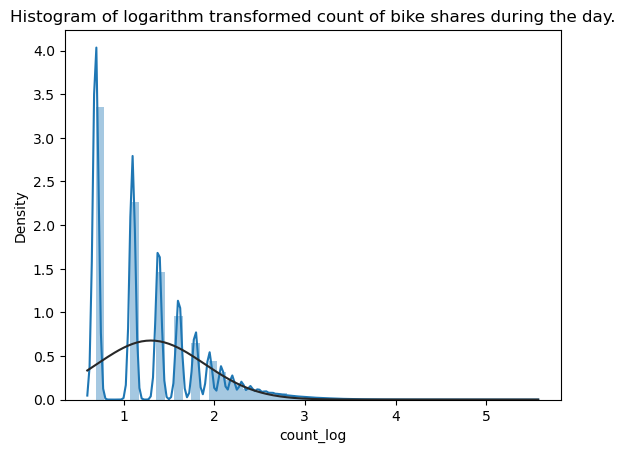

In [25]:
sns_hist(london[london['is_night']==0]['count_log'],"Histogram of logarithm transformed count of bike shares during the day.")

In [26]:
#london["timestamp"] = pd.to_datetime(london["timestamp"], errors = 'ignore')

seasons = {
    "Spring": [3, 4, 5],
    "Summer": [6, 7, 8],
    "Autumn": [9, 10, 11],
    "Winter": [12, 1, 2]
}
seasonal_dataframes = {}

# Loop through the seasons dictionary to create a dataframe for each season
for season, months in seasons.items():
    # Filter the data for the specific months
    season_data = london[london['timestamp'].dt.month.isin(months)]
    # Group by both month and day and count
    grouped_by_month_day = season_data.groupby([season_data['timestamp'].dt.month.rename("Month"), season_data['timestamp'].dt.day.rename("Day")]).size()
    # Reset index to make it a dataframe with month and day as columns
    grouped_by_month_day_df = grouped_by_month_day.reset_index(name='Count')
    # Store the dataframe in the dictionary with the season as the key
    seasonal_dataframes[season] = grouped_by_month_day_df


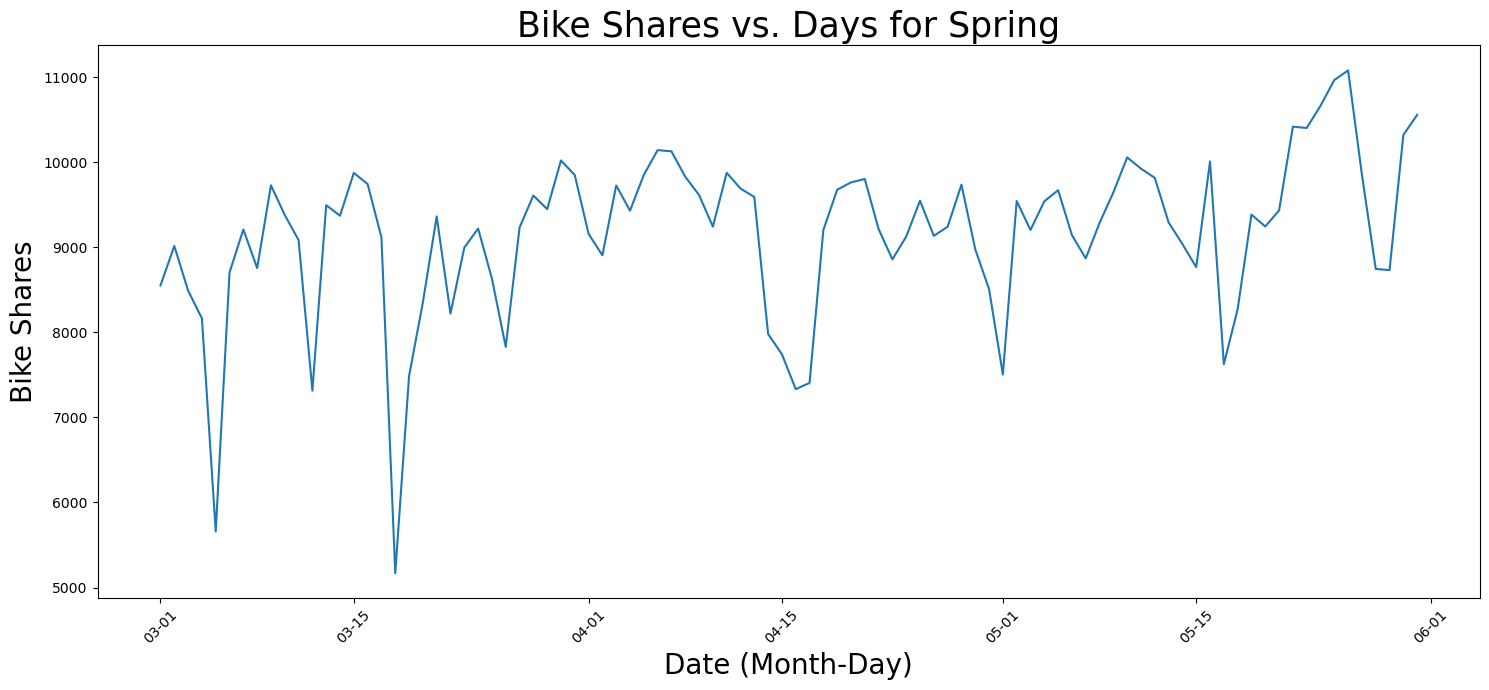

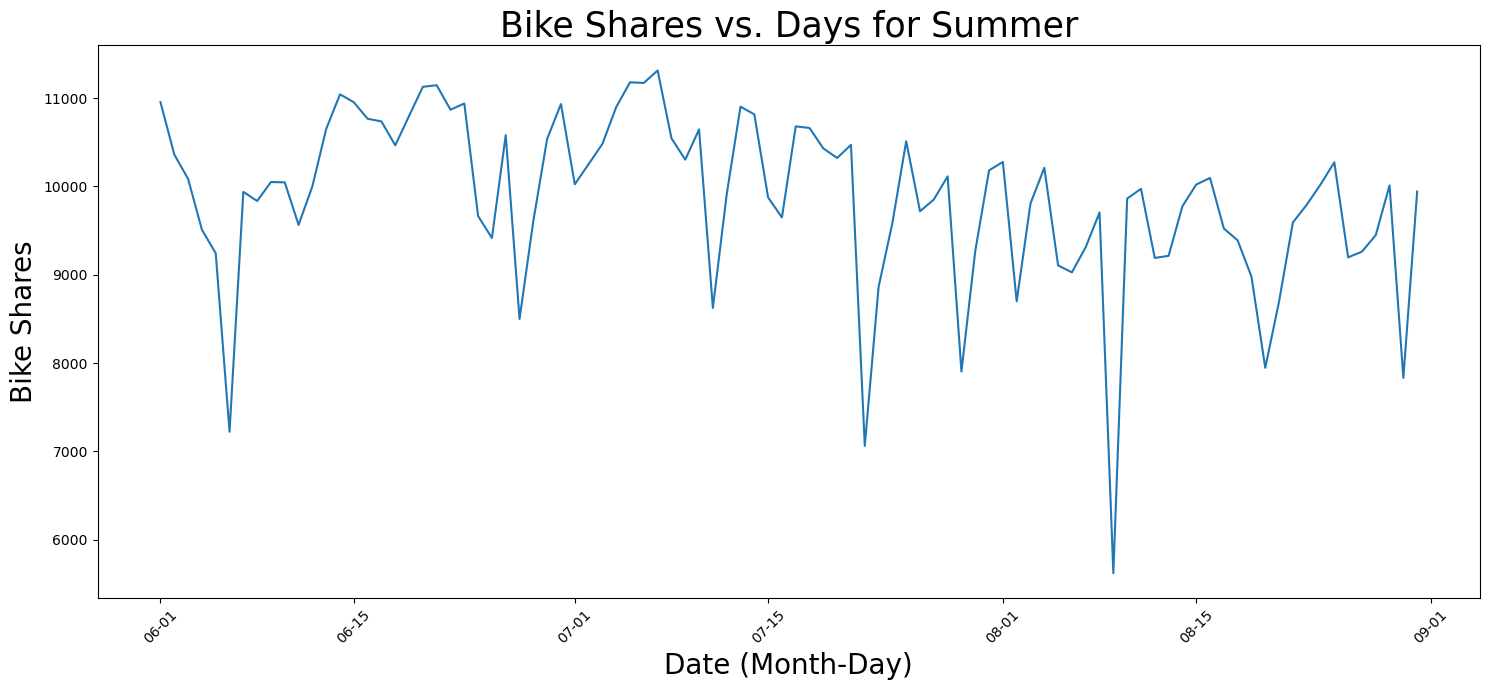

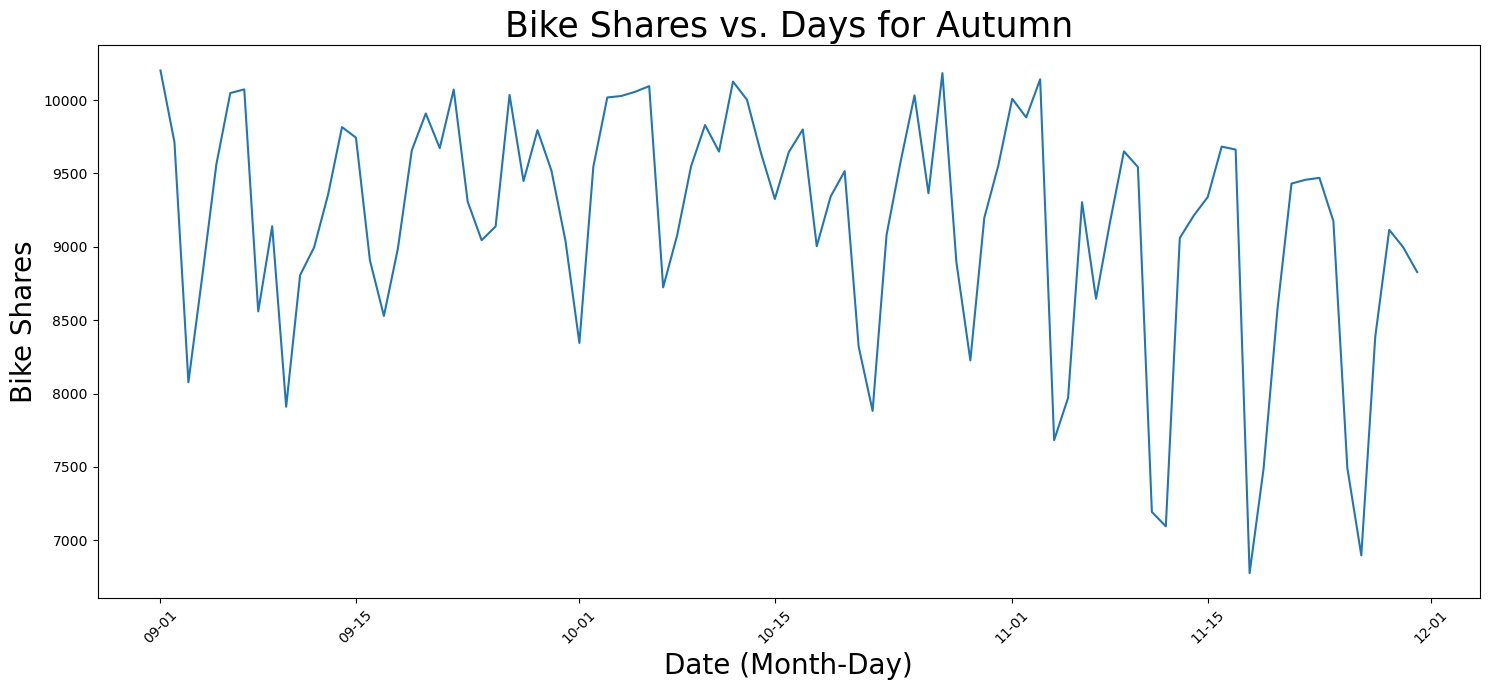

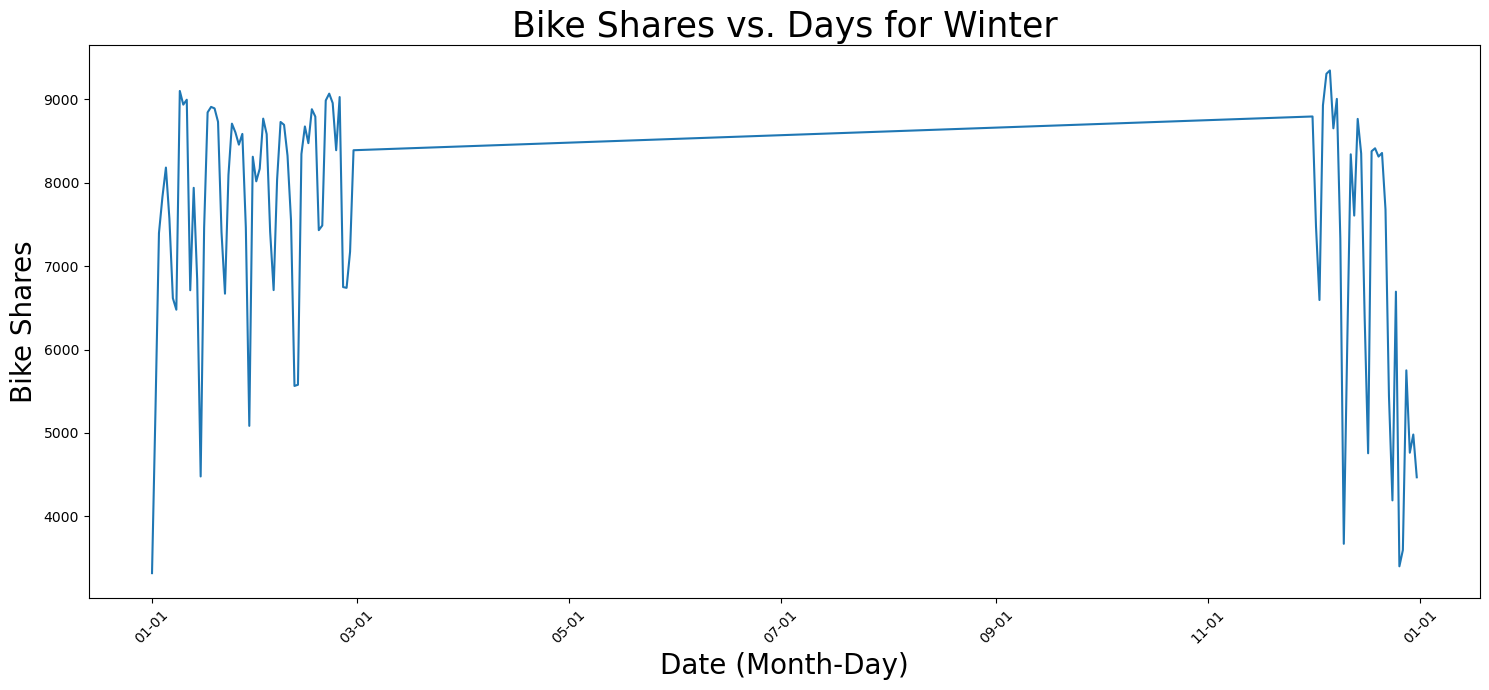

In [27]:
from matplotlib.dates import DateFormatter
for season, df in seasonal_dataframes.items():
    # Combine 'Month' and 'Day' into a 'Date' column for clearer plotting
    # This assumes 'Month' and 'Day' are numeric columns.
    df['Date'] = pd.to_datetime(df[['Month', 'Day']].assign(Year=2017))  # Use a common leap year for correct day count

    plt.figure(figsize=(15, 7))
    ax = sns.lineplot(x='Date', y='Count', data=df)
    ax.set_title(f"Bike Shares vs. Days for {season}", fontsize=25)
    ax.set_xlabel("Date (Month-Day)", fontsize=20)
    ax.set_ylabel('Bike Shares', fontsize=20)
    
    # Setting date format on x-axis
    date_form = DateFormatter("%m-%d")
    ax.xaxis.set_major_formatter(date_form)
    
    # Improve the x-tick labels to prevent them from overlapping
    plt.xticks(rotation=45)  # Rotate labels to avoid clutter
    plt.tight_layout()  # Adjust layout to make room for label rotation
    
    plt.show()



## ML

In [50]:
print(london.columns)

Index(['StartStation Id', 'cnt', 'timestamp', 'real_temp', 'humidity',
       'feel_temp', 'precipitation', 'rain', 'snowfall', 'weather_code',
       'cloud_cover', 'wind_speed', 'count_log', 'is_holiday', 'is_weekend',
       'month', 'day', 'hour', 'year', 'hour_sin', 'hour_cos', 'month_sin',
       'month_cos', 'is_night'],
      dtype='object')


In [28]:
london_df = london.drop(['timestamp','cnt'],axis=1)
X = london_df.drop(['count_log'], axis=1)
y = london_df['count_log']
scaler_x = preprocessing.MinMaxScaler()
X =  pd.DataFrame(scaler_x.fit_transform(X), columns = X.columns)

In [29]:
def df_split(df,train_percent):
    """
    Function to split DataFrame/Series on percentage value.
    Input:
    -------
    -df - pandas DataFrame
    -train_percent - the percentage /100 of the data that we want to split. value between [0,1]
    
    Output:
    --------
    -two pandas DataFrames
    """
    split_index = int(train_percent * len(df))
    train = df.iloc[:split_index]
    test = df.iloc[split_index:]
    return train,test

In [30]:
X_train,X_test = df_split(X,0.7)
y_train,y_test = df_split(y,0.7)

In [39]:
X_train.shape

(2279452, 21)

In [40]:
y_train.shape

(2279452,)

In [41]:
X_test.shape

(976908, 21)

In [42]:
y_test.shape

(976908,)

In [43]:
london.shape

(3256360, 24)

C:\Users\jkaed\AppData\Local\Temp\ipykernel_21128\3045206472.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data, fit=norm)


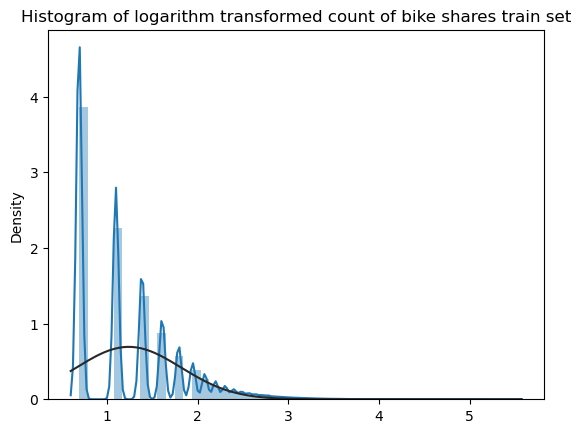

In [44]:
sns_hist(pd.DataFrame(y_train),"Histogram of logarithm transformed count of bike shares train set")

C:\Users\jkaed\AppData\Local\Temp\ipykernel_21128\3045206472.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data, fit=norm)


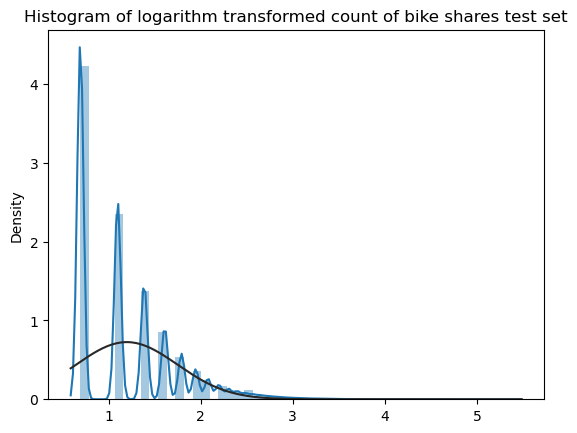

In [45]:
sns_hist(pd.DataFrame(y_test),"Histogram of logarithm transformed count of bike shares test set")
# sns.distplot(pd.DataFrame(y_test), fit=norm)
# plt.title("Histogram of logarithm transformed count of bike shares test set")
# plt.ylabel('Density')

In [31]:
def rmsle(y, y_pred):
    """
    Root squared logarithmic loss function.
    The function is trimming the negative values and replace them with 0. After that calculates the RMSLE.
    Input:
    y - true values
    y_pred - predicted values

    Output: RMSLE
    """
    assert(y.shape == y_pred.shape)
    y = np.expm1(y)
    y_pred=y_pred.clip(min=0)
    y_pred=y_pred.clip(max=10)
    y_pred = np.expm1(y_pred)
    return np.sqrt(mean_squared_log_error( y, y_pred))


rmsle_scorer = make_scorer(rmsle, greater_is_better=False)
tscv = TimeSeriesSplit(n_splits=5)

In [32]:
columns = ['weather_code']#,'season','is_non_workday']
X_dummies = pd.get_dummies(X_train, columns=columns)
X_dummies = X_dummies.drop(['day','year','month'],axis=1)


In [33]:
def assym_loss(y_val, y_pred):
    grad = np.where((y_val - y_pred)<0, -2*50.0*(y_val - y_pred), -2*(y_val - y_pred))
    hess = np.where((y_val - y_pred)<0, 2*50.0, 2.0)
    return grad, hess

In [ ]:
def test_algorithms():
    
    """
    A custom function designed for cross validation score on "london bike sharing dataset".
    The function is comparing the following algorithms :
    "LinearRegression", "Random Forrest", "XGBoost", "SVR" , "AdaBoost","BaggingRegressor",
    on "London bicycle sharing dataset" with mean RMSLE error, standard deviation on RMSLE and execution time. 
    The output of this function is a pandas dataframe.
    """
    names = ["LinearRegression", 
             #"Random Forrest",
             "XGBoost",
             "AsymmetricalXGBoost",
             #"SVR" ,
             #"AdaBoost",
             #"BaggingRegressor"
            ]
    
    regressors = [
        LinearRegression(),
        #RandomForestRegressor(random_state=42),
        XGBRegressor(objective ='reg:squarederror',random_state=42),
        XGBRegressor(objective =assym_loss,random_state=42),
        #SVR(),
        #AdaBoostRegressor(random_state=42),
        #BaggingRegressor(random_state=42)    
    ]
    
    data_X = [X_dummies,X_train ,X_train ,X_dummies ,X_train ,X_train ]
    reg_columns=['algorithm','score_rmsle_mean','score_std','time']
    reg_performance = pd.DataFrame(columns=reg_columns)
    print('Wait 1-2 minutes for all algorithms to complete.')
    for name, regressor, X_trains in zip(names, regressors,data_X):
        time_start = time.time()
        cv_results = cross_val_score(regressor, X_trains,y_train, cv=5 ,scoring = rmsle_scorer)
        time_end = round(time.time() - time_start,3)
        mean_score = round(-cv_results.mean(),4)
        std_score = round(cv_results.std(),4)
        t= pd.DataFrame([[name,mean_score,std_score,time_end]],columns = reg_columns)
        reg_performance = pd.concat([reg_performance, t])
        print(name , ' RMSLE = ',mean_score , 'with std=',std_score ," execution_time =  ", time_end,"s")
    return reg_performance
reg_performance = test_algorithms()
reg_performance

In [ ]:
def plot_performance(df,x,y, filename):
    """
    Function to bar plot algorithm performance.
    Inputs
    -------
    - df: DataFrame generated by test_algorithms() function
    - x: x column name, usually 'algorithm'
    - y: y column name - 'score_rmsle_mean' or 'time'
    
    Returns
    -------
    Barplot of the performance
    """
    #assert_is_not_none(df)
    #assert_true(x in set(df.columns))
    #assert_true(y in set(df.columns))
    
    plt.figure(figsize=(6, 5))
    sns.barplot(data=df, x=x,y=y)
    #plt.title('Comparative Analysis of Machine Learning Model Accuracy by RMSLE')
    plt.ylabel("Root Mean Squared Logarithmic Error (RMSLE)")
    plt.xlabel("")
    plt.xticks(rotation=0)
    plt.savefig(filename)

plot_performance(reg_performance, x='algorithm',y='score_rmsle_mean', filename="alg_accuracy_rmsle_barplot.png")


## Cross validation

In [52]:
#################CAUTION LONG_RUNNING_CODE#####################################
# Uncomment the desired section to cross validate the diffrent models 

"""
The following code is used to optimize 3 machine learning algorithms and export
the trained models to a pickle file. Uncomment if needed to check the results.

"""


def save_pickle(model):
    """
    Export sklearn trained model to a file.
    Input:
    ----------
    - model:sklearn trained model
    """
    
    pickle.dump(model, open(model.__class__.__name__ + '.model', 'wb'))
    print('Model saved as ' + model.__class__.__name__ + '.model')

###############################################################################
# ###########################XGBoost############################################
# grid_values = {'learning_rate': [0.001, 0.01, 0.1, 0.3],
#               'n_estimators':[100,700,1000,1200],
#               'max_depth': [3,5,8,10],
#               #'min_child_weight': [1,2,3,4],
#               #'gamma':[0, 0.1, 0.2, 0.3]
#               #'reg_alpha': [0.1,1,200,500],#L1
#               #'reg_lambda':[1,200,500],#L2
#               }



# grid_xgb = GridSearchCV(XGBRegressor(objective = 'reg:squarederror', eval_metric="rmse",random_state=42),#early_stopping_rounds=20,
#                        n_jobs=-1, param_grid = grid_values,cv=tscv,scoring = rmsle_scorer)
# grid_xgb.fit(X_train, y_train)
# save_pickle(grid_xgb.best_estimator_)
# pd.DataFrame(grid_xgb.cv_results_).to_csv('XGB_cv_results.csv')
# #############################################################################
###########################ASSYMMETRICAL XGBoost############################################ takes 2 hours
grid_values = {'learning_rate': [0.001, 0.01, 0.1, 0.3],
              'n_estimators':[100,700,1000,1200],
              'max_depth': [3,5,8,10],
              #'min_child_weight': [1,2,3,4],
              #'gamma':[0, 0.1, 0.2, 0.3]
              #'reg_alpha': [0.1,1,200,500],#L1
              #'reg_lambda':[1,200,500],#L2
              }
grid_asym_xgb = GridSearchCV(XGBRegressor(objective = assym_loss, eval_metric="rmse",random_state=42),#early_stopping_rounds=20,
                       n_jobs=-1, param_grid = grid_values,cv=tscv,scoring = rmsle_scorer)
grid_asym_xgb.fit(X_train, y_train)
pickle.dump(grid_asym_xgb, open(grid_asym_xgb.__class__.__name__ + '_assym_.model', 'wb'))
#print('Model saved as ' + grid_asym_xgb.__class__.__name__ + '.model')
pd.DataFrame(grid_asym_xgb.cv_results_).to_csv('AsymXGB_cv_results.csv')
############################################################################
#####################RandomForrest###########################################

# grid_values_rf = {'n_estimators': [10,100,500,750,1000,1200],
#                  'max_depth' : [5,7,8,9],
#                  'min_samples_leaf': [5,10,25,50],
#                #'max_features': ['auto', 'sqrt'],
#                }

# grid_rf = GridSearchCV(RandomForestRegressor(random_state=42), param_grid = grid_values_rf,cv=tscv,scoring = rmsle_scorer)
# grid_rf.fit(X_train, y_train)
# save_pickle(grid_rf.best_estimator_)
# pd.DataFrame(grid_rf.cv_results_).to_csv('RF_cs_results.csv')
# ###############################################################################
# #######################BaggringRegressor#######################################
# grid_values_br = {'n_estimators':[10,100,500,1000]}

# grid_br = GridSearchCV(BaggingRegressor(random_state=42) , param_grid = grid_values_br,cv=tscv,scoring = rmsle_scorer)
# grid_br.fit(X_train, y_train)

# #################save_pickle(grid_br.best_estimator_)#####skipped due very long size on disk
# pd.DataFrame(grid_br.cv_results_).to_csv('BR_cv_results.csv')
################################################################################
################################################################################

In [36]:
def load_pickle(url):
    """
    Funtion to load existing trained model, previously saved by pickle.
    Inputs
    -------
    - url: DataFrame generated by test_algorithms() function
    
    Returns
    -------
    - sklearn trained model
    
    """
    try:
        loaded_model = pickle.load(url)
        print('Model loaded.')
        return loaded_model
    except:
        print('Unable to load the model from url.')
        return 0

In [37]:
file = open('AsymXGBRegressor.model', 'rb')
file1 = open('XGBRegressor.model', 'rb')

#xgb_tuned = load_pickle(file1)
asym_xgb_tuned = load_pickle(file)
xgb_tuned = load_pickle(file1)

#assert_is_not_none(xgb_tuned)
#rf_tuned = load_pickle(rf_model_url)
#assert_is_not_none(rf_tuned)

Model loaded.
Model loaded.


The "cv_results" from the GridSearchCV are also exported and the code below shows the top 3 hyperparameter combinations, their RMSLE score and training time of every algorithm.

In [38]:
asym_xgb_cv = pd.read_csv("AsymXGB_cv_results.csv")
xgb_cv = pd.read_csv("XGB_cv_results.csv")
#rf_cv = pd.read_csv(rf_results_url)
#br_cv = pd.read_csv(br_results_url)

In [39]:
asym_xgb_cv[asym_xgb_cv['rank_test_score']<4]
#xgb_cv[xgb_cv['rank_test_score']<4]

,Unnamed: 0,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
45,45,416.691084,193.154899,24.594754,1.003674,0.1,10,700,"{'learning_rate': 0.1, 'max_depth': 10, 'n_est...",-0.589884,-0.651128,-0.637235,-0.723169,-0.715700,-0.663423,0.050095,3
46,46,589.868642,271.199175,30.765442,2.180997,0.1,10,1000,"{'learning_rate': 0.1, 'max_depth': 10, 'n_est...",-0.583337,-0.636309,-0.642684,-0.713193,-0.709182,-0.656941,0.048867,2
47,47,704.828641,318.648762,37.630718,1.912119,0.1,10,1200,"{'learning_rate': 0.1, 'max_depth': 10, 'n_est...",-0.581992,-0.632166,-0.648852,-0.705173,-0.704919,-0.654620,0.046686,1


In [40]:
xgb_cv[xgb_cv['rank_test_score']<4]

,Unnamed: 0,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
39,39,163.973193,78.026023,18.541135,0.862214,0.1,5,1200,"{'learning_rate': 0.1, 'max_depth': 5, 'n_esti...",-0.464675,-0.489136,-0.504679,-0.500551,-0.498469,-0.491502,0.014348,3
41,41,133.236749,59.449448,24.270911,0.919721,0.1,8,700,"{'learning_rate': 0.1, 'max_depth': 8, 'n_esti...",-0.465074,-0.485536,-0.505009,-0.498543,-0.496415,-0.490115,0.014004,1
42,42,190.094749,87.915643,34.355998,1.440334,0.1,8,1000,"{'learning_rate': 0.1, 'max_depth': 8, 'n_esti...",-0.467626,-0.486195,-0.506711,-0.498735,-0.496405,-0.491134,0.013455,2


In [42]:
def convert_df(df,name):
    """
    Function to convert the cv_result DataFrame for plotting.
    
    Inputs
    -------
    - df: DataFrame generated by GridSearchCV
    - name: name of the algorithm tuned with GridSearchCV
    
    Returns
    -------
    - converted DataFrame suitable for barplot
    """
    #assert_is_not_none(df)
    #assert_is_instance(df, pd.DataFrame)
    test_set = set(['rank_test_score','split0_test_score','split1_test_score','split2_test_score',
                   'split3_test_score','split4_test_score'])
    #assert_true(test_set.issubset(set(df.columns)))

    
    t = df[df['rank_test_score']==1][['split0_test_score','split1_test_score','split2_test_score','split3_test_score','split4_test_score']]
    t = -t.T
    t=t.reset_index()
    t.columns=['algorithm','RMSLE_score']
    t.algorithm = name
    return t
clean = convert_df(xgb_cv,'XGBoost')
asym_clean = convert_df(asym_xgb_cv,'AsymXGBoost')
#clean = clean.append(convert_df(rf_cv,'RandomForest'))
#clean = clean.append(convert_df(br_cv,'BaggingRegressor'))
clean

,algorithm,RMSLE_score
0,XGBoost,0.465074
1,XGBoost,0.485536
2,XGBoost,0.505009
3,XGBoost,0.498543
4,XGBoost,0.496415


In [43]:
asym_clean

,algorithm,RMSLE_score
0,AsymXGBoost,0.581992
1,AsymXGBoost,0.632166
2,AsymXGBoost,0.648852
3,AsymXGBoost,0.705173
4,AsymXGBoost,0.704919


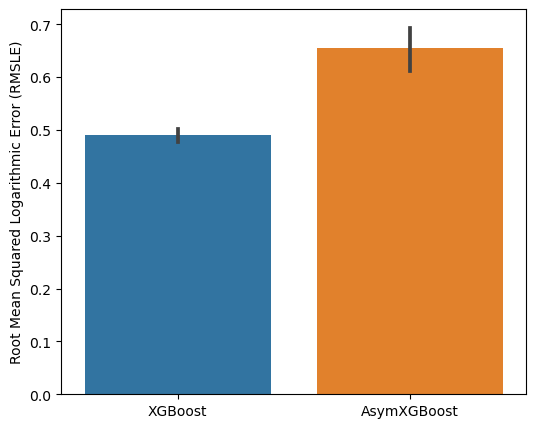

In [44]:
barplot=pd.concat([clean, asym_clean], axis=0)
plot_performance(barplot, x='algorithm',y='RMSLE_score', filename="rmsle_barplot.png")

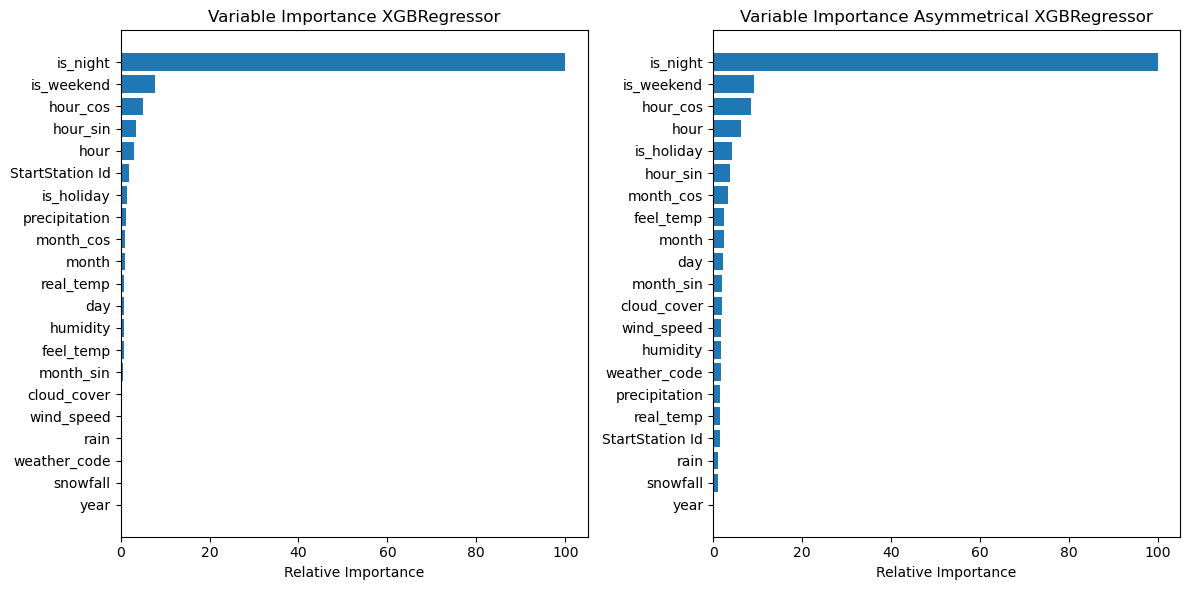

In [45]:
import matplotlib.pyplot as plt
import numpy as np

def plot_importance(model1, model2, modelname1, modelname2):
    """
    Function to plot variable importance from two machine learning models side by side.
    Note: Each model requires to have "model.feature_importances_".
    
    Inputs
    -------
    - model1: the first model with an object ".feature_importances_"
    - model2: the second model with an object ".feature_importances_"
    - modelname1: name of the first model
    - modelname2: name of the second model

    Returns
    -------
    - Two feature importance plots side by side
    

    """
    # Extracting feature importances from both models
    feature_importance1 = model1.feature_importances_
    feature_importance2 = model2.feature_importances_
    
    # Making importances relative to max importance
    feature_importance1 = 100.0 * (feature_importance1 / feature_importance1.max())
    feature_importance2 = 100.0 * (feature_importance2 / feature_importance2.max())
    
    sorted_idx1 = np.argsort(feature_importance1)
    sorted_idx2 = np.argsort(feature_importance2)
    
    pos1 = np.arange(sorted_idx1.shape[0]) + .5
    pos2 = np.arange(sorted_idx2.shape[0]) + .5
    
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
    
    axes[0].barh(pos1, feature_importance1[sorted_idx1], align='center')
    axes[0].set_yticks(pos1)
    axes[0].set_yticklabels(X_train.columns[sorted_idx1])
    axes[0].set_xlabel('Relative Importance')
    axes[0].set_title(f'Variable Importance {modelname1}')
    
    axes[1].barh(pos2, feature_importance2[sorted_idx2], align='center')
    axes[1].set_yticks(pos2)
    axes[1].set_yticklabels(X_train.columns[sorted_idx2])
    axes[1].set_xlabel('Relative Importance')
    axes[1].set_title(f'Variable Importance {modelname2}')
    
    fig.tight_layout()
    plt.savefig("combination_plot_variable_importance.png")
    plt.show()

plot_importance(xgb_tuned, asym_xgb_tuned, "XGBRegressor", "Asymmetrical XGBRegressor")
# plot_importance(xgb_tuned, "XGBRegressor")
# plot_importance(asym_xgb_tuned, "Asymmetrical XGBRegressor")

## Scoring on the testing set.

In [89]:
def plot_scores(model,X_train,y_train):

    assert(y_train.shape[0] == X_train.shape[0])
    
    print("Model parameters ", model.__class__.__name__)
    prediction_train = np.expm1((model.predict(X_train).clip(min=0)))
    y_train = np.expm1(y_train)
    print("Root Mean Squared Error: " + str(np.sqrt(mean_squared_error(y_train, prediction_train))))
    print("Mean Absolute Error: " + str(mean_absolute_error(y_train, prediction_train)))
    print("R^2 Coefficient of Determination: " + str(r2_score(y_train, prediction_train)))
    print('RMSLE:', np.sqrt(mean_squared_log_error(y_train, prediction_train)))

##LINEAR VALUES 

In [90]:
plot_scores(xgb_tuned,X_test,y_test)
print('-------')
plot_scores(asym_xgb_tuned,X_test,y_test)

Model parameters  XGBRegressor
Root Mean Squared Error: 3.4596355389296383
Mean Absolute Error: 1.6043398065562393
R^2 Coefficient of Determination: 0.2288917924788565
RMSLE: 0.4605978673067763
-------
Model parameters  XGBRegressor
Root Mean Squared Error: 4.211905342800852
Mean Absolute Error: 1.9128352743752353
R^2 Coefficient of Determination: -0.1429094695229982
RMSLE: 0.6556866320522962


In [140]:
import matplotlib.pyplot as plt

plt.figure(figsize=(18, 8))
plt.plot(np.expm1(y_test), label='True Values')
plt.plot((np.expm1(y_test) - np.expm1(xgb_tuned.predict(X_test))), label='Predicted Values')
plt.legend()
plt.savefig(f'./XGBoost_predictions.png')
plt.close()

plt.figure(figsize=(18, 8))
plt.plot(np.expm1(y_test), label='True Values')
plt.plot((np.expm1(y_test) - np.expm1(asym_xgb_tuned.predict(X_test))), label='Predicted Values')
plt.legend()
plt.savefig(f'./Asym_XGBoost_predictions.png')
plt.close()

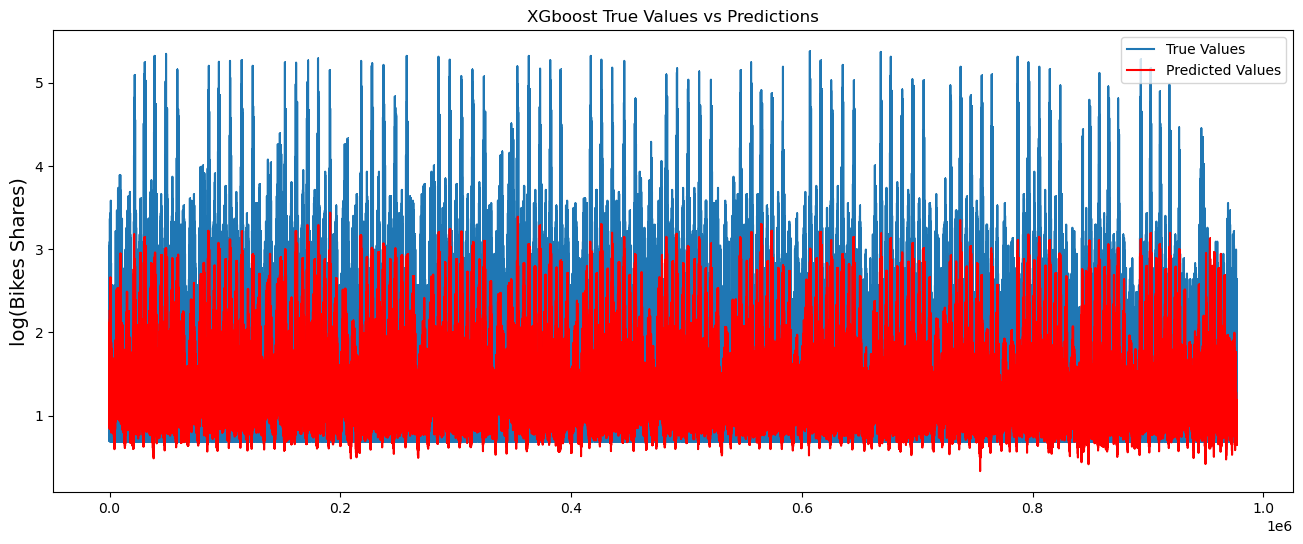

In [173]:
import matplotlib.pyplot as plt

preds= xgb_tuned.predict(X_test)

plt.figure(figsize=(16,6))

plt.plot(y_test.values,marker=",",label="actual")
plt.plot(preds,marker=",",label="prediction",color="red")

plt.ylabel(ylabel='log(Bikes Shares)', fontsize=14)
plt.title('XGboost True Values vs Predictions')
plt.legend(['True Values', 'Predicted Values'])
plt.savefig(f'./true_vs_pred_xgb_log_full.png')

plt.show()

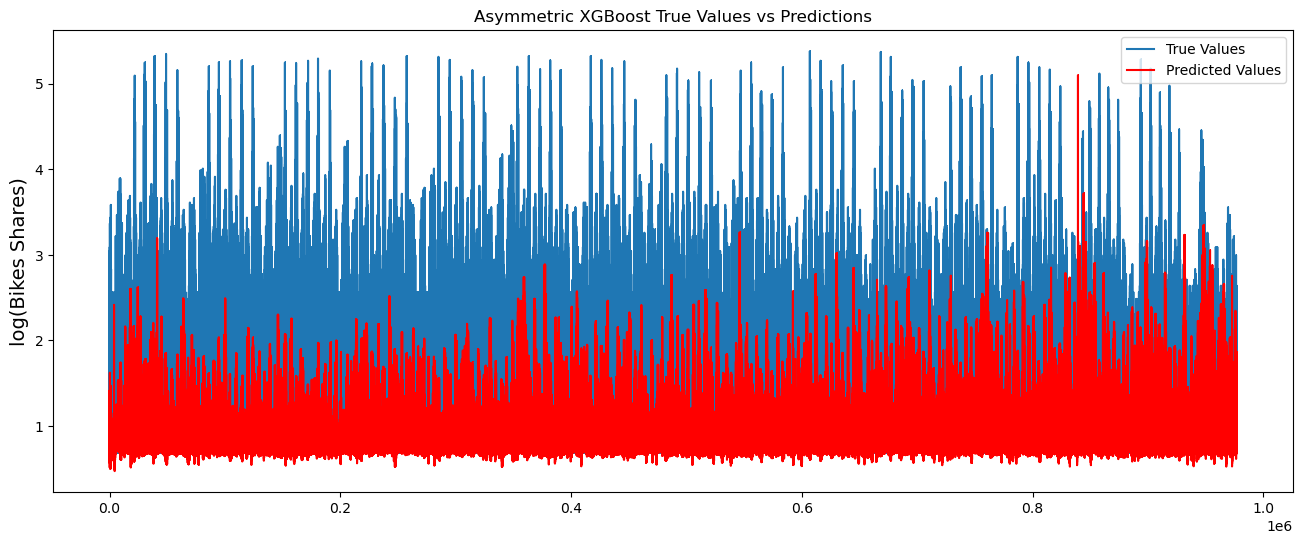

In [178]:
import matplotlib.pyplot as plt

preds= asym_xgb_tuned.predict(X_test)

plt.figure(figsize=(16,6))

plt.plot(y_test.values,marker=",",label="actual")
plt.plot(preds,marker=",",label="prediction",color="red")

plt.ylabel(ylabel='log(Bikes Shares)', fontsize=14)
plt.title('Asymmetric XGBoost True Values vs Predictions')
plt.legend(['True Values', 'Predicted Values'])
plt.savefig(f'./true_vs_pred_asym_xgb_log_full.png')

plt.show()

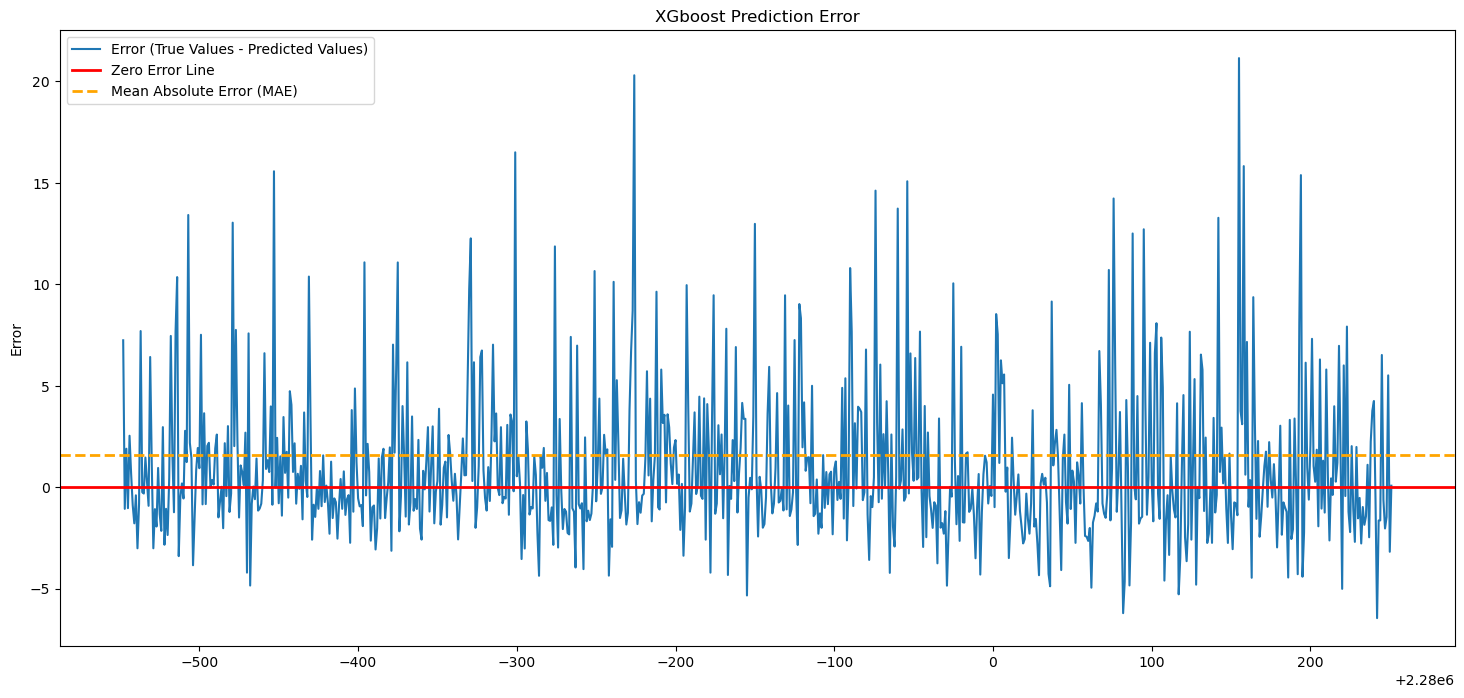

In [175]:
import numpy as np
import matplotlib.pyplot as plt

# Calculate the error
error = np.expm1(y_test[0:800]) - np.expm1(xgb_tuned.predict(X_test[0:800]))

# Plotting the error
plt.figure(figsize=(18, 8))
#plt.plot(np.expm1(y_test.values), label='Y_test')
#
plt.plot(error, label='Error (True Values - Predicted Values)')

plt.axhline(0, color='red', linewidth=2, label='Zero Error Line')
plt.axhline(1.6043398065562393, color='orange', linestyle='--', linewidth=2, label='Mean Absolute Error (MAE)')
#plt.axhline(-1.6043398065562393, color='orange', linestyle='--', linewidth=2) # For negative MAE
plt.legend()
plt.title('XGboost Prediction Error')
plt.ylabel('Error')
plt.savefig(f'./err_xgb_linear_split.png')
plt.show()

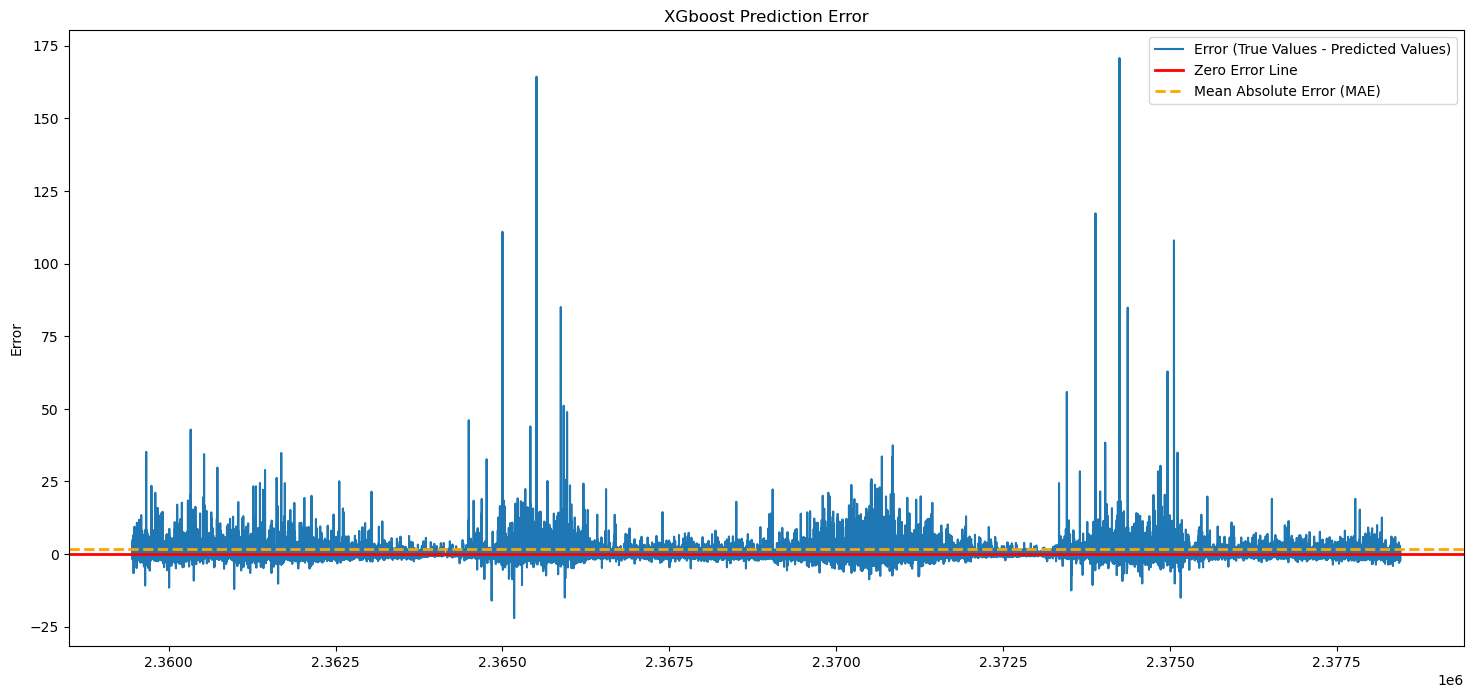

In [177]:
import numpy as np
import matplotlib.pyplot as plt

# Calculate the error
error = np.expm1(y_test[80000:99000]) - np.expm1(xgb_tuned.predict(X_test[80000:99000]))

# Plotting the error
plt.figure(figsize=(18, 8))
#plt.plot(np.expm1(y_test.values), label='Y_test')
#
plt.plot(error, label='Error (True Values - Predicted Values)')

plt.axhline(0, color='red', linewidth=2, label='Zero Error Line')
plt.axhline(1.6043398065562393, color='orange', linestyle='--', linewidth=2, label='Mean Absolute Error (MAE)')
#plt.axhline(-1.6043398065562393, color='orange', linestyle='--', linewidth=2) # For negative MAE
plt.legend()
plt.title('XGboost Prediction Error')
plt.ylabel('Error')
plt.savefig(f'./err_xgb_linear_bigger_split.png')
plt.show()

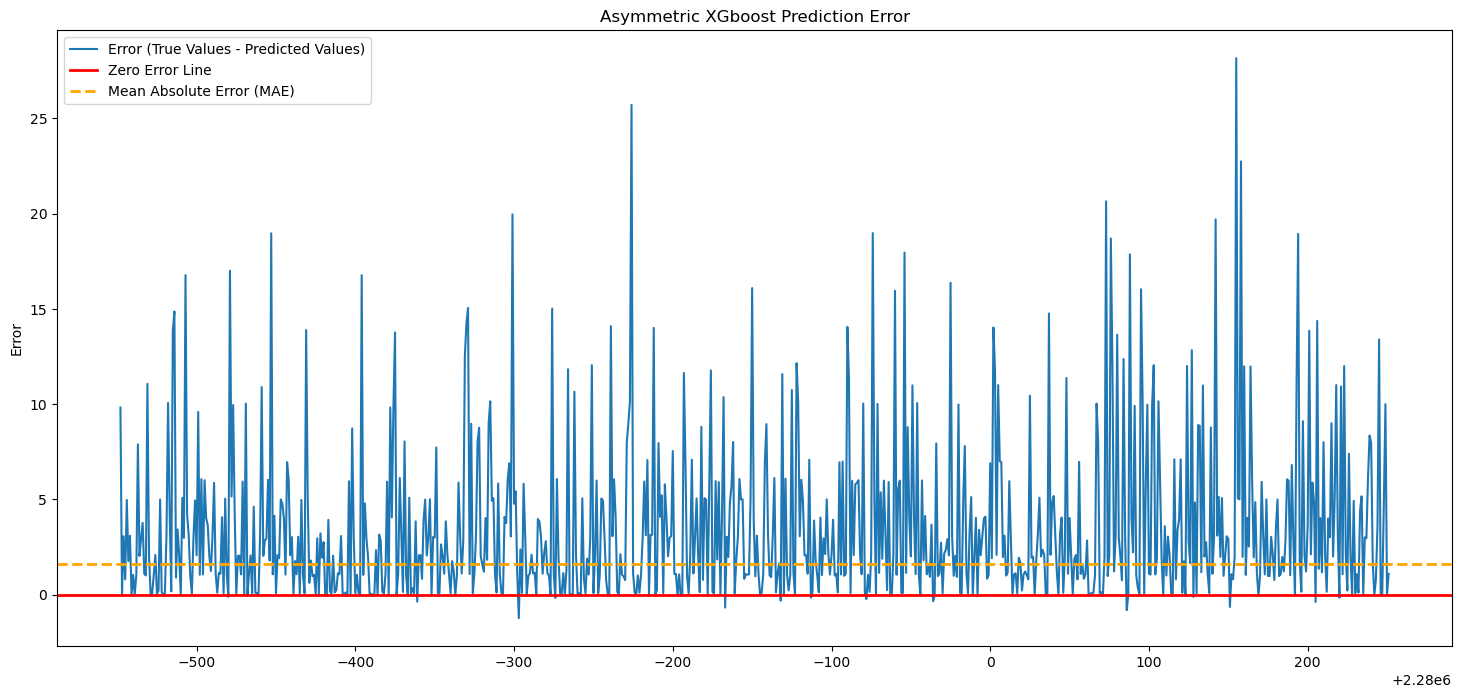

In [172]:
import numpy as np
import matplotlib.pyplot as plt

# Calculate the error
error = np.expm1(y_test[0:800]) - np.expm1(asym_xgb_tuned.predict(X_test[0:800]))

# Plotting the error
plt.figure(figsize=(18, 8))
#plt.plot(np.expm1(y_test.values), label='Y_test')
#
plt.plot(error, label='Error (True Values - Predicted Values)')

plt.axhline(0, color='red', linewidth=2, label='Zero Error Line')
plt.axhline(1.6043398065562393, color='orange', linestyle='--', linewidth=2, label='Mean Absolute Error (MAE)')
#plt.axhline(-1.6043398065562393, color='orange', linestyle='--', linewidth=2) # For negative MAE
plt.legend()
plt.title('Asymmetric XGboost Prediction Error over 800')
plt.ylabel('Error')
plt.savefig(f'./err_asym_xgb_linear_split.png')
plt.show()

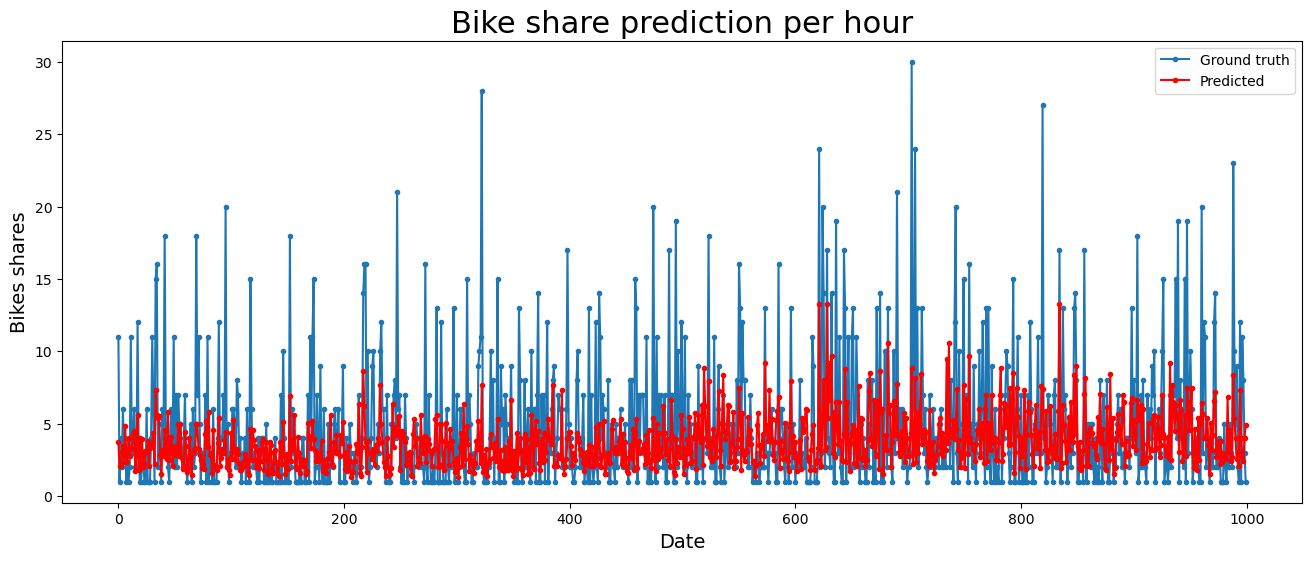

In [145]:
import matplotlib.pyplot as plt

preds= xgb_tuned.predict(X_test)

plt.figure(figsize=(16,6))

plt.plot(np.expm1(y_test[0:1000].values),marker=".",label="actual")
plt.plot(np.expm1(preds[0:1000]),marker=".",label="prediction",color="r")

plt.title('Bike share prediction per hour', fontsize=22)
plt.xlabel(xlabel='Date', fontsize=14)
plt.ylabel(ylabel='Bikes shares', fontsize=14)
plt.legend(['Ground truth', 'Predicted'])

plt.show()

In [64]:
import matplotlib.pyplot as plt
import numpy as np

xgb_errors = np.abs(np.expm1(y_test) - np.expm1(xgb_tuned.predict(X_test)))

# Calculate the absolute differences for the Asymmetric XGBoost model
asym_xgb_errors = np.abs(np.expm1(y_test) - np.expm1(asym_xgb_tuned.predict(X_test)))


# Plot the error for the XGBoost model
plt.figure(figsize=(18, 8))
plt.plot(xgb_errors, label='Error (XGBoost)')
plt.xlabel('Data Point')
plt.ylabel('Error')
plt.title('Error Plot for XGBoost Model')
plt.legend()
plt.savefig(f'./XGBoost_errors.png')
plt.close()

# Plot the error for the Asymmetric XGBoost model
plt.figure(figsize=(18, 8))
plt.plot(asym_xgb_errors, label='Error (Asymmetric XGBoost)')
plt.xlabel('Data Point')
plt.ylabel('Error')
plt.title('Error Plot for Asymmetric XGBoost Model')
plt.legend()
plt.savefig(f'./Asym_XGBoost_errors.png')
plt.close()


In [67]:
algo_xgb = xgb_tuned.predict(X_test)
algo_asym = asym_xgb_tuned.predict(X_test)
mean =  (np.expm1(algo_xgb) + np.expm1(algo_asym))/2
mean_log = np.log1p(mean)
print("RMSLE of combined XGBoost and ASYM = ",rmsle(y_test,mean_log))

RMSLE of combined XGBoost and ASYM =  0.5045002322508332


Performing a D’Agostino’s K^2 Test for a normal distribution of residuals.
H0 = The distribution is Gaussian.P value to reject H0 is p= 0.05 = 5%
Statistics=39087.545, p=0.00000
The distribution does not look Gaussian (H0 is rejected)


C:\Users\jkaed\AppData\Local\Temp\ipykernel_24144\802495902.py:36: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(res, fit=norm, ax = axs[1]);


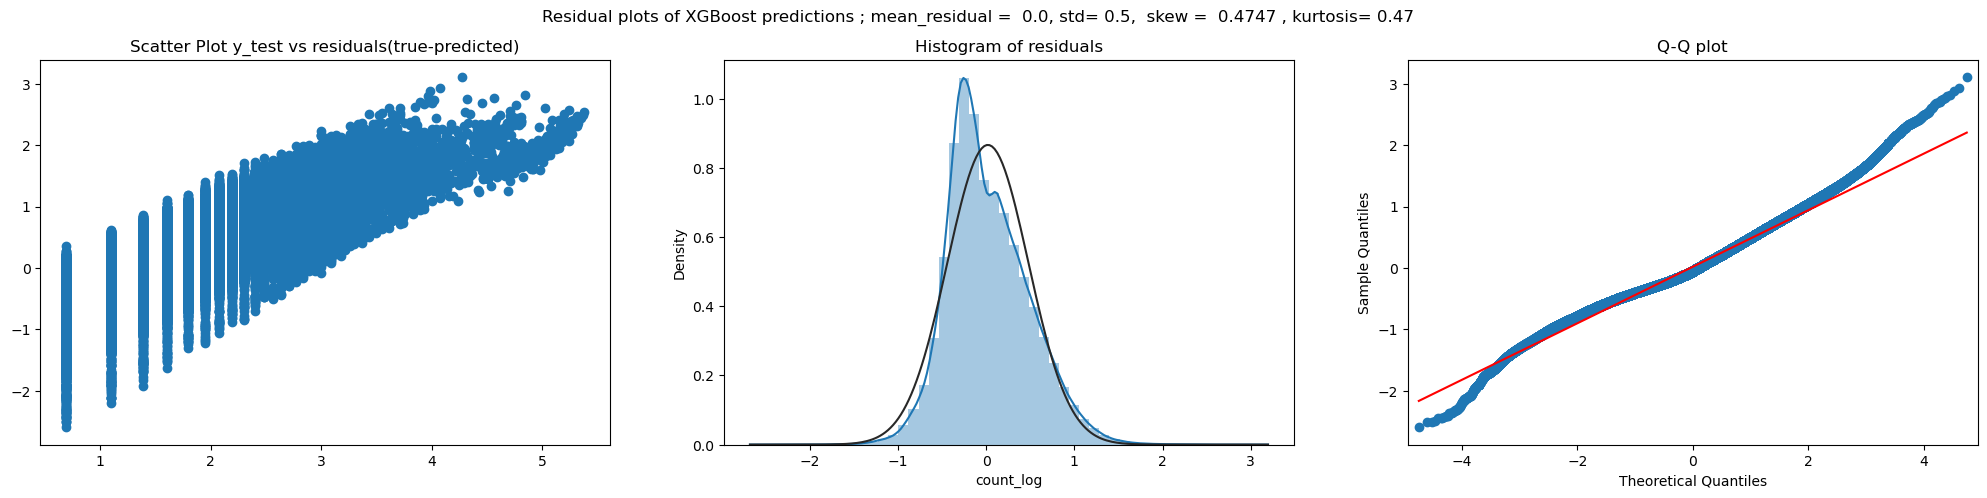

Performing a D’Agostino’s K^2 Test for a normal distribution of residuals.
H0 = The distribution is Gaussian.P value to reject H0 is p= 0.05 = 5%
Statistics=114867.815, p=0.00000
The distribution does not look Gaussian (H0 is rejected)


C:\Users\jkaed\AppData\Local\Temp\ipykernel_24144\802495902.py:36: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(res, fit=norm, ax = axs[1]);


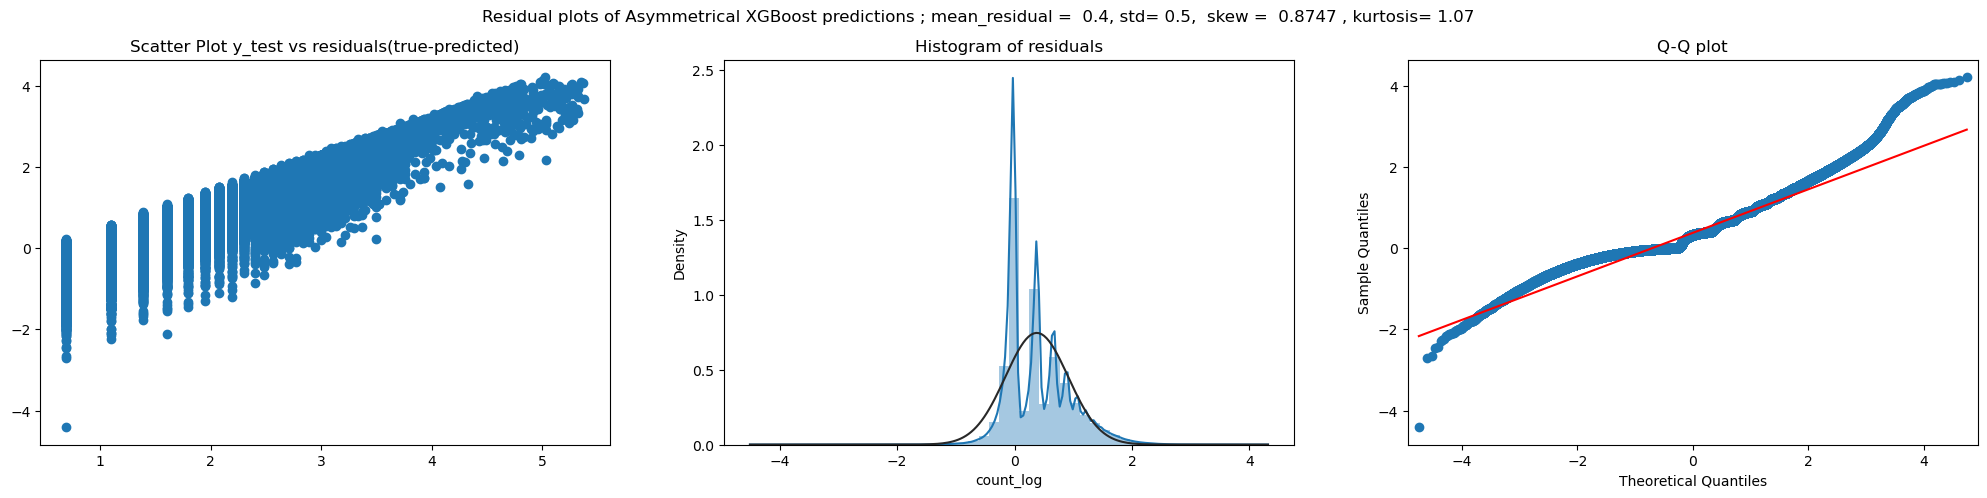

In [107]:
def residual_plot(y_test, y_predicted,main_title):
    """
    Function to plot the residual distribution calculated from y_test and y_predicted.
    
    Inputs
    -------
    - y_test: the log transformed target values
    - y_predicted: raw predictions from the algorithm
    - main_title: main title of the plot
    
    Returns
    -------
    - a plot containing 3 subplots: Scatter plot, Histogram and Q-Q plot
    
    
    """
    res =  y_test - y_predicted #era così: np.expm1(y_test) - np.expm1(y_predicted)
    fig, axs = plt.subplots(1,3, figsize=(25, 5))
    ##D’Agostino’s K^2 Test
    stat, p = stats.normaltest(res)
    print("Performing a D’Agostino’s K^2 Test for a normal distribution of residuals.")
    print("H0 = The distribution is Gaussian.P value to reject H0 is p= 0.05 = 5%")
    print('Statistics=%.3f, p=%.5f' % (stat, p))
    # interpretation of the test
    alpha = 0.05
    if p > alpha:
        print("failed to reject H0 (H0 = The distribution is Gaussian).Can't accept any hypothesis. ")
    else:
        print('The distribution does not look Gaussian (H0 is rejected)')
    #End of D’Agostino’s K^2 Test
    #Begin of plotting
    plt.suptitle(f'{main_title} ; mean_residual =  {res.mean():.1f}, std= {res.std():.1f},  skew =  {res.skew():.4f} , kurtosis= {res.kurtosis():.2f}'  )
    axs[0].title.set_text('Scatter Plot y_test vs residuals(true-predicted)')
    axs[0].scatter((y_test),res)
    axs[1].title.set_text('Histogram of residuals')
    sns.distplot(res, fit=norm, ax = axs[1]);
    axs[2].title.set_text('Q-Q plot')
    sm.qqplot(res, line='s', ax=axs[2])#era così: stats.t, distargs=(4,),line = 's', ax=axs[2])
    #plt.savefig('./Asym_XGBoost_residuals_plots.png')  # Save the figure
    plt.show()

residual_plot(y_test, xgb_tuned.predict(X_test) ,"Residual plots of XGBoost predictions")
residual_plot(y_test, asym_xgb_tuned.predict(X_test) ,"Residual plots of Asymmetrical XGBoost predictions")


In [69]:
print('---------Model evaluation on train set---------------')
plot_scores(xgb_tuned,X_train,y_train)
print('\n--------Model evaluation on test set---------------')
plot_scores(xgb_tuned,X_test,y_test)

print('---------AssymmXGBOOST evaluation on train set---------------')
plot_scores(asym_xgb_tuned,X_train,y_train)
print('\n--------AssymmXGBOOST evaluation on test set---------------')
plot_scores(asym_xgb_tuned,X_test,y_test)
# print('\n---------Model evaluation on train set---------------')
# plot_scores(rf_tuned,X_train,y_train)
# print('\n--------Model evaluation on test set---------------')
# plot_scores(rf_tuned,X_test,y_test)

---------Model evaluation on train set---------------
Model parameters  XGBRegressor
Root Mean Squared Error: 3.717731010878446
Mean Absolute Error: 1.7204387172476312
R^2 Coefficient of Determination: 0.26622956468160464
RMSLE: 0.4618276055694745

--------Model evaluation on test set---------------
Model parameters  XGBRegressor
Root Mean Squared Error: 3.4596355389296383
Mean Absolute Error: 1.6043398065562393
R^2 Coefficient of Determination: 0.2288917924788565
RMSLE: 0.4605978673067763
---------AssymmXGBOOST evaluation on train set---------------
Model parameters  XGBRegressor
Root Mean Squared Error: 4.675314424980341
Mean Absolute Error: 2.119883043172762
R^2 Coefficient of Determination: -0.16044865146467724
RMSLE: 0.7056351933687072

--------AssymmXGBOOST evaluation on test set---------------
Model parameters  XGBRegressor
Root Mean Squared Error: 4.211905342800852
Mean Absolute Error: 1.9128352743752353
R^2 Coefficient of Determination: -0.1429094695229982
RMSLE: 0.65568663205

In [57]:
print('---------Model evaluation on train set---------------')
plot_scores_linear(xgb_tuned,X_train,y_train)
print('\n--------Model evaluation on test set---------------')
plot_scores_linear(xgb_tuned,X_test,y_test)

print('---------AssymmXGBOOST evaluation on train set---------------')
plot_scores_linear(asym_xgb_tuned,X_train,y_train)
print('\n--------AssymmXGBOOST evaluation on test set---------------')
plot_scores_linear(asym_xgb_tuned,X_test,y_test)
# print('\n---------Model evaluation on train set---------------')
# plot_scores(rf_tuned,X_train,y_train)
# print('\n--------Model evaluation on test set---------------')
# plot_scores(rf_tuned,X_test,y_test)

---------Model evaluation on train set---------------
Model parameters:  XGBRegressor
Root Mean Squared Error (Linear - on Log Scale): 0.4618276055634777
Mean Absolute Error (Linear - on Log Scale): 0.36735115592439993
R^2 Coefficient of Determination (Linear - on Log Scale): 0.35708877946565465
RMSLE (Linear - on Log Scale): 0.4618276055694745

--------Model evaluation on test set---------------
Model parameters:  XGBRegressor
Root Mean Squared Error (Linear - on Log Scale): 0.4605978673013245
Mean Absolute Error (Linear - on Log Scale): 0.3659124222643326
R^2 Coefficient of Determination (Linear - on Log Scale): 0.29832269739894257
RMSLE (Linear - on Log Scale): 0.4605978673067763
---------AssymmXGBOOST evaluation on train set---------------
Model parameters:  XGBRegressor
Root Mean Squared Error (Linear - on Log Scale): 0.7056351934227869
Mean Absolute Error (Linear - on Log Scale): 0.4914726633701815
R^2 Coefficient of Determination (Linear - on Log Scale): -0.5008997774225652
RMSL